## 验证用户每关的retry time和global retry time是否存在线性关系

In [269]:
import numpy as np
import pandas as pd

from tqdm.notebook import tqdm

import scipy
from matplotlib import pyplot as plt

1. load and preprocess

In [96]:
# load data
original_data = pd.read_csv("../data/Data_process/Cox_feature_interaction_part_last.csv")
original_data["win"] = original_data["last_win"].shift(-1)
original_data.fillna(0,inplace=True)

In [101]:
all_data = original_data

In [98]:
max_length = 160

In [102]:
# length clamp
all_data = all_data.loc[all_data.session_depth<max_length]
all_data["event"] = all_data.loc[:,"session_length"].apply(lambda x: x<=max_length)
all_data["cut_length"] = all_data.loc[:,"session_length"].apply(lambda x: min(x,max_length))

/work/lijiayu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/work/lijiayu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [100]:
all_data.columns

Index(['user_id', 'session_length', 'level_id', 'game_weekday', 'hour',
       'session_id', 'day_session', 'last_item', 'last_win', 'last_duration',
       'last_energy', 'session_depth', 'avg_item', 'avg_duration',
       'avg_passrate', 'global_retrytime', 'retry_time', 'last_one',
       'last_oneday', 'last_3day', 'last_oneweek', 'win', 'event',
       'cut_length'],
      dtype='object')

2. 提取出想探究线性关系的两个变量，所有win对应的log: user，retry time，global retry time

__按照global retry time做level index__

In [104]:
retry_data = all_data.loc[all_data.win==1].groupby(["user_id","level_id"]).head(1)
retry_data = retry_data.loc[:,["user_id","global_retrytime","retry_time","level_id"]]
global_retrytime = list(set(retry_data.global_retrytime.tolist()))
global_rt_dict = dict(zip(sorted(global_retrytime),list(range(1,len(global_retrytime)+1))))
global_rt_rdict = dict(zip(list(range(1,len(global_retrytime)+1)),sorted(global_retrytime)))

In [107]:
retry_data["rt_level"] = retry_data.global_retrytime.apply(lambda x: global_rt_dict[x])

In [143]:
level_info = retry_data.groupby(["level_id"]).agg({"rt_level":"mean"}).reset_index()

In [120]:
retry_data.head()

,user_id,global_retrytime,retry_time,level_id,rt_level
0,1,0.062977,0,1,19
1,1,0.009521,0,2,7
2,1,0.007835,0,3,6
3,1,0.014470,0,4,10
4,1,0.050676,0,5,17


In [145]:
retry_dedup = retry_data.groupby(["user_id","global_retrytime"]).agg({"retry_time":"mean"}).reset_index()

In [205]:
retry_dedup.head()

,user_id,global_retrytime,retry_time
0,1,0.007798,0.0
1,1,0.007835,0.0
2,1,0.009521,0.0
3,1,0.012780,0.0
4,1,0.014470,0.0


3. Fit the lineary = ax+b

In [405]:
def plot_linear(x,y, a,b, uid=0,savefig=False,filename=""):
    # scatter original data, plot the linear ax+b
    plt.figure(figsize=(10,5))
    ax = plt.subplot()
    ax.scatter(x,y,s=2)
    ax.plot(x,a*x+b,color='r')
    ax.set_xlabel("level difficulty (global retry time)",fontsize=16)
    ax.set_ylabel("user's retry time",fontsize=16)
    ax.set_title("User %d"%(uid),fontsize=18)
    if savefig:
        plt.savefig("figures/"+filename)
    plt.show()

3.1 直接用global retry time与pass retry time做线性拟合

In [397]:
uidlist, alist, blist, selist,lenlist, selist_all = [],[],[],[],[],[]
for uid in tqdm(set(retry_dedup.user_id.tolist())):
    uidlist.append(uid)
    x = retry_dedup.loc[retry_dedup.user_id==uid].global_retrytime.to_numpy()
    y = retry_dedup.loc[retry_dedup.user_id==uid].retry_time.to_numpy()
    A = np.vstack([x,np.ones(len(x))]).T
    results = np.linalg.lstsq(A,y, rcond=None)
    alist.append(results[0][0])
    blist.append(results[0][1])
    selist.append(results[1][0]/len(x))
    selist_all.append(results[1][0])
    lenlist.append(len(x))
fit_results_one = pd.DataFrame(np.array([uidlist, alist, blist, selist,lenlist,selist_all]).T,
                           columns=["user_id","a","b","s_e","length","s_e_all"])


In [398]:
fit_results_one.corr()

,user_id,a,b,s_e,length,s_e_all
user_id,1.000000,0.048506,-0.029862,0.021755,-0.011741,0.009022
a,0.048506,1.000000,-0.220451,0.251134,-0.063491,0.130745
b,-0.029862,-0.220451,1.000000,0.283309,0.176547,0.195215
s_e,0.021755,0.251134,0.283309,1.000000,0.497766,0.835611
length,-0.011741,-0.063491,0.176547,0.497766,1.000000,0.736182
s_e_all,0.009022,0.130745,0.195215,0.835611,0.736182,1.000000


In [400]:
fit_results_one.describe()

,user_id,a,b,s_e,length,s_e_all
count,1896.000000,1896.000000,1896.000000,1896.000000,1896.000000,1896.000000
mean,1000.214135,0.641828,0.361071,11.843336,223.213080,3809.388390
std,575.232646,0.586921,0.591529,13.763593,170.253513,6489.643482
min,1.000000,-0.397683,-3.526865,0.000000,8.000000,0.000000
25%,505.750000,0.372914,0.040904,2.433656,114.000000,278.698163
50%,1006.500000,0.551377,0.268730,6.939036,161.000000,1237.076625
75%,1493.250000,0.777249,0.592858,16.568604,282.000000,4597.417892
max,2000.000000,16.124471,5.531396,106.789303,962.000000,83818.433719


In [403]:
top_fit = fit_results_one.sort_values(by="s_e").head(20)
worst_fit = fit_results_one.sort_values(by="s_e").tail(20)

user id: 1316, a: 0.61, b:0.25, length: 332


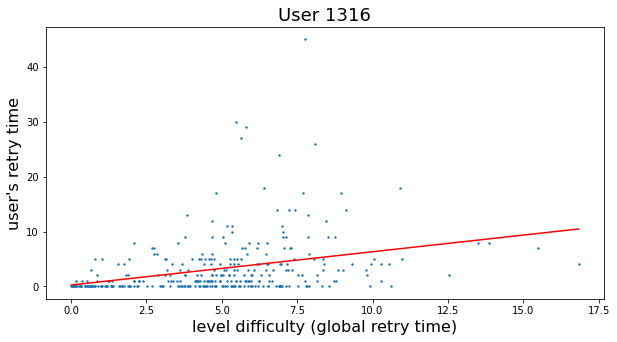

In [422]:
row = fit_results_one.loc[fit_results_one.user_id==1316]
print("user id: %d, a: %.2f, b:%.2f, length: %d"%(row.user_id,row.a,row.b,row.length))
    
uid = row.user_id.tolist()[0]
x = retry_dedup.loc[retry_dedup.user_id==uid].global_retrytime.to_numpy()
y = retry_dedup.loc[retry_dedup.user_id==uid].retry_time.to_numpy()
plot_linear(x,y,row.a.tolist()[0],row.b.tolist()[0],uid=uid)

user id: 1772, a: 1.43, b:0.25, length: 458


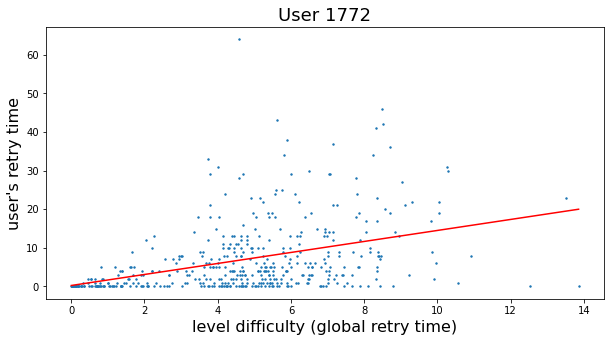

user id: 1139, a: 0.86, b:0.77, length: 560


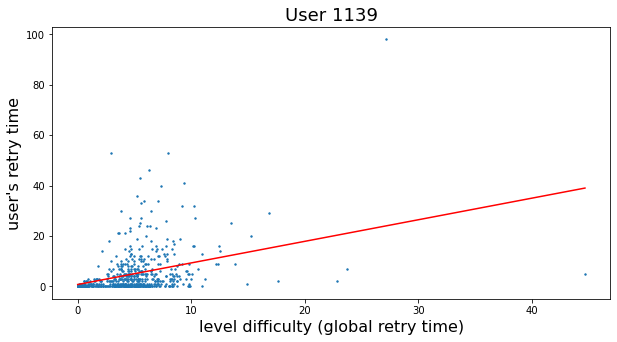

user id: 466, a: 0.77, b:2.08, length: 555


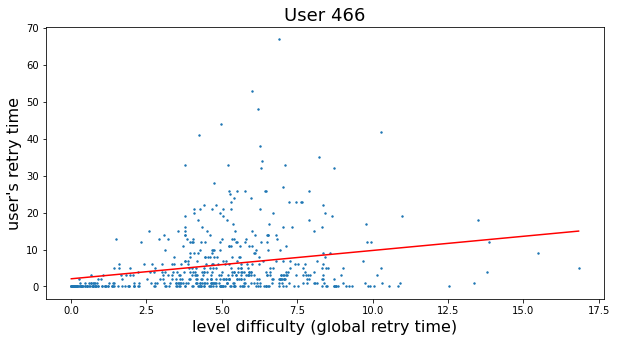

user id: 655, a: 1.18, b:1.51, length: 270


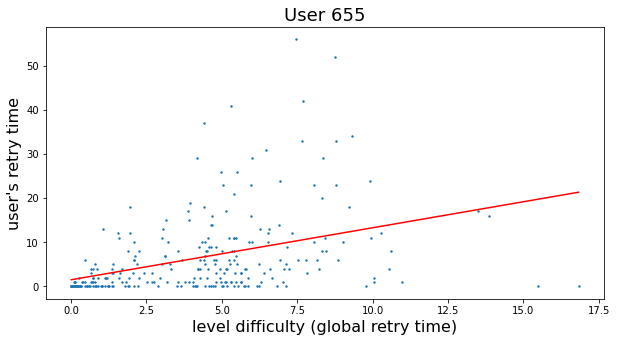

user id: 353, a: 1.23, b:0.30, length: 590


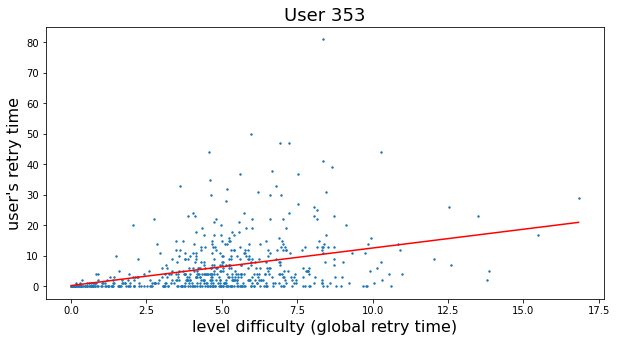

user id: 1438, a: 1.33, b:-0.56, length: 631


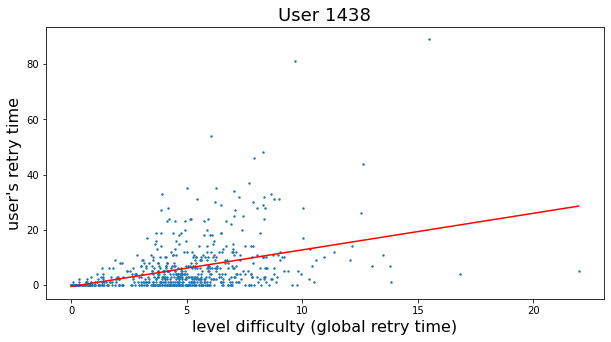

user id: 252, a: 1.27, b:0.15, length: 482


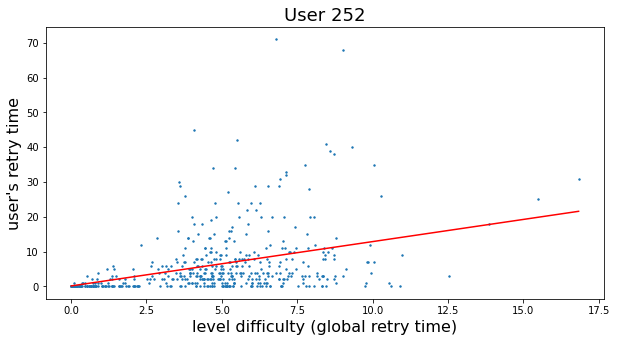

user id: 546, a: 4.00, b:0.73, length: 111


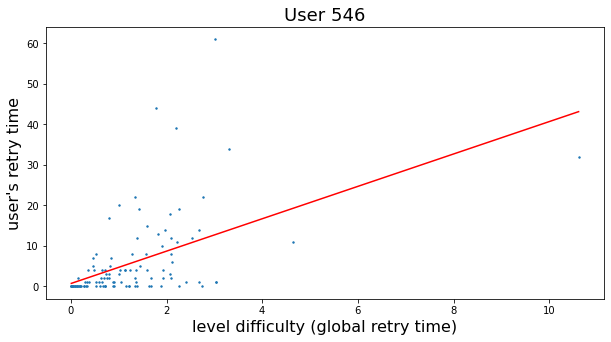

user id: 514, a: 1.01, b:2.54, length: 259


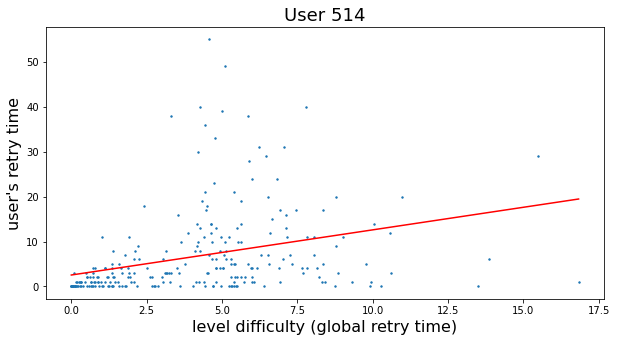

user id: 784, a: 0.96, b:1.88, length: 513


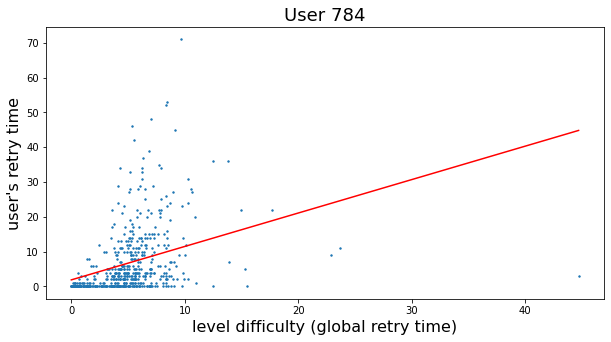

user id: 195, a: 1.26, b:0.32, length: 822


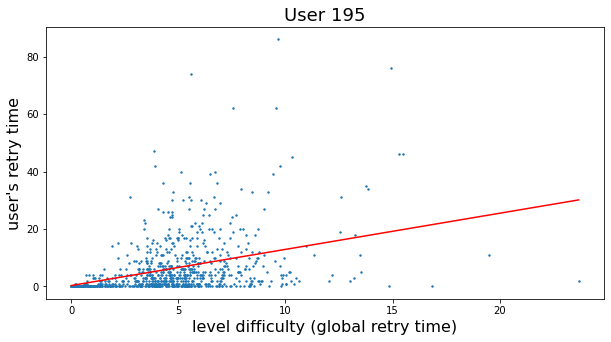

user id: 1722, a: 2.05, b:1.49, length: 25


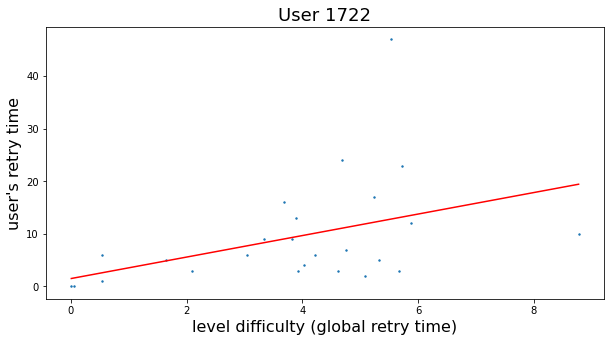

user id: 457, a: 1.00, b:2.27, length: 312


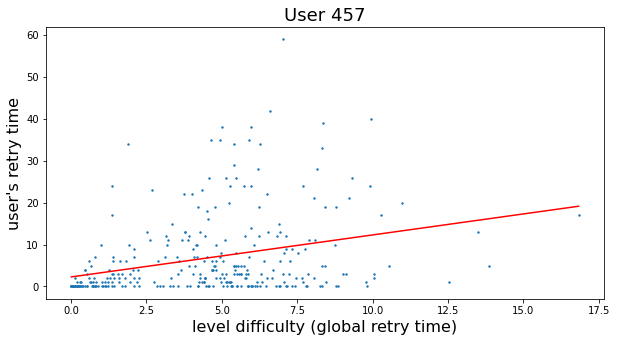

user id: 239, a: 1.31, b:0.90, length: 427


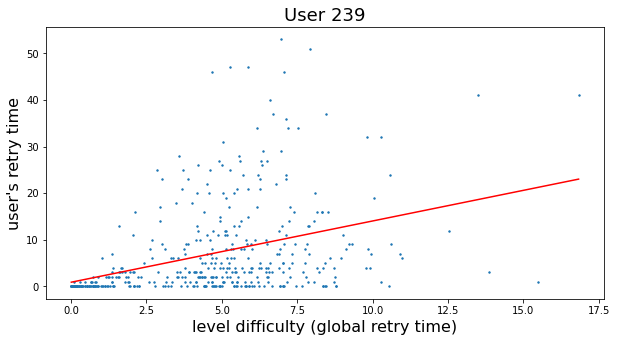

user id: 1192, a: 1.30, b:2.06, length: 84


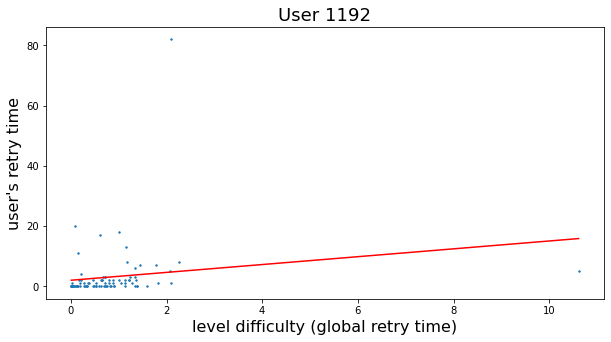

user id: 1105, a: 1.44, b:-0.56, length: 675


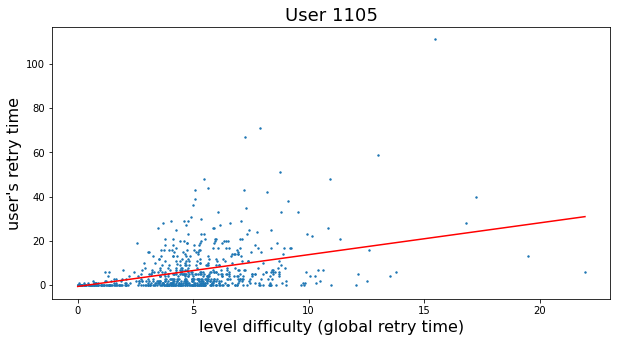

user id: 915, a: 1.15, b:0.37, length: 331


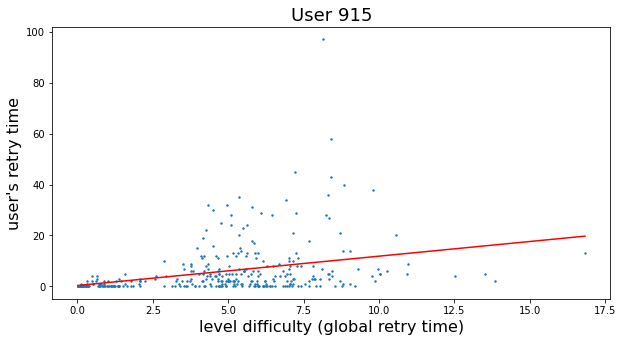

user id: 1446, a: 1.00, b:2.98, length: 264


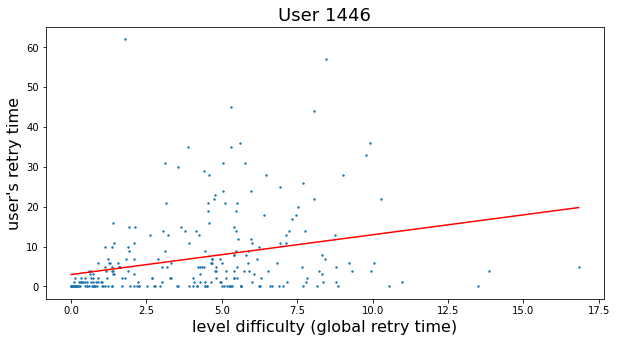

user id: 1929, a: 1.31, b:1.11, length: 786


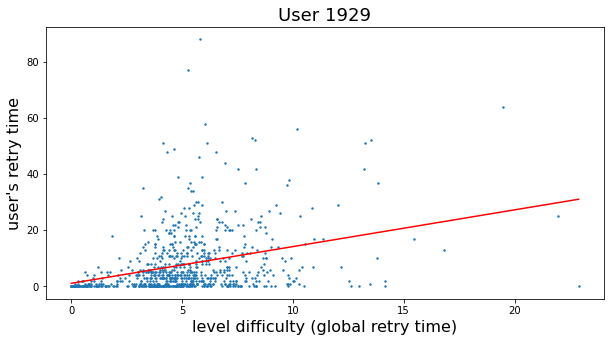

user id: 1726, a: 0.43, b:5.47, length: 134


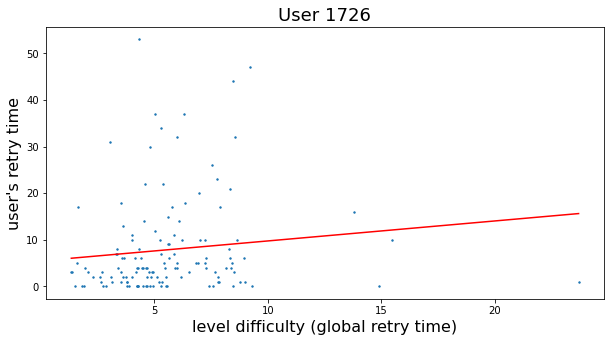

In [406]:
for row in worst_fit.iterrows():
    print("user id: %d, a: %.2f, b:%.2f, length: %d"%(row[1].user_id,row[1].a,row[1].b,row[1].length))
    
    uid = row[1].user_id
    x = retry_dedup.loc[retry_dedup.user_id==uid].global_retrytime.to_numpy()
    y = retry_dedup.loc[retry_dedup.user_id==uid].retry_time.to_numpy()
    plot_linear(x,y,row[1].a,row[1].b,uid=uid)

user id: 1122, a: 0.00, b:0.00, length: 93


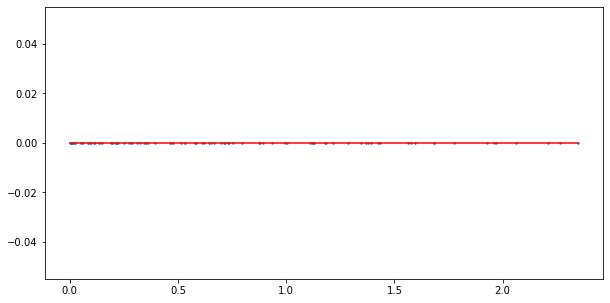

user id: 1966, a: 0.31, b:-0.03, length: 22


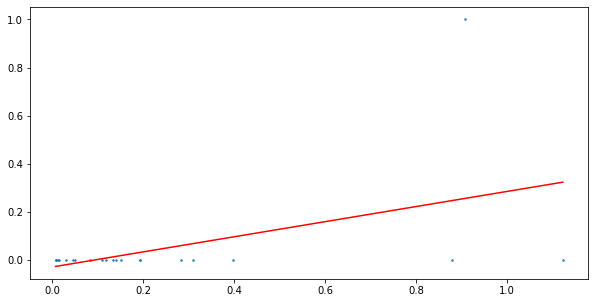

user id: 198, a: 0.14, b:-0.04, length: 31


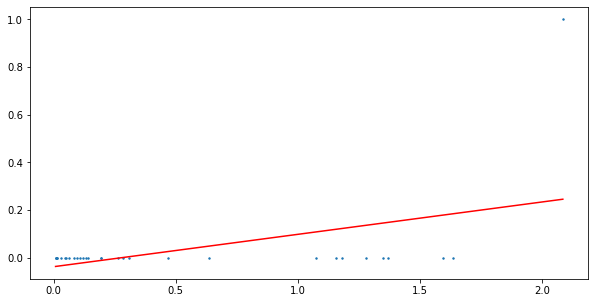

user id: 1804, a: 0.06, b:0.02, length: 26


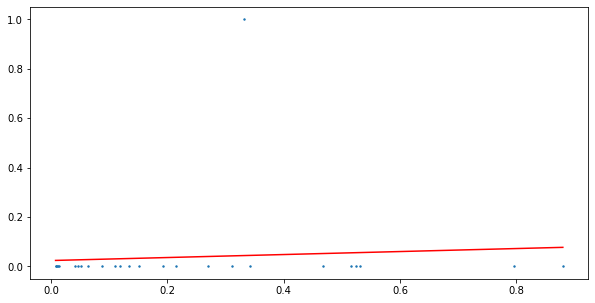

user id: 1502, a: 0.28, b:-0.06, length: 44


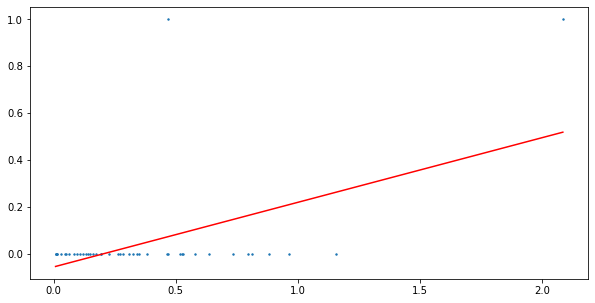

user id: 1492, a: 0.37, b:0.08, length: 16


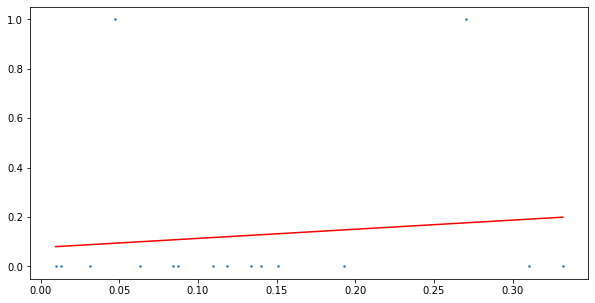

user id: 411, a: 0.03, b:0.01, length: 44


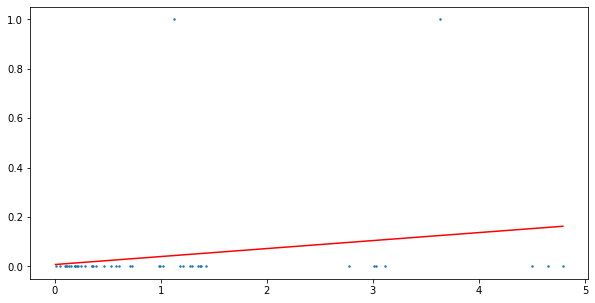

user id: 369, a: 0.06, b:0.04, length: 34


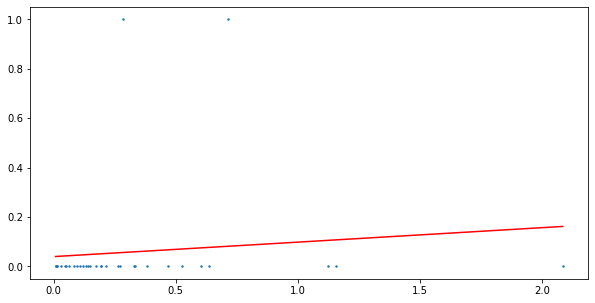

user id: 29, a: -0.02, b:0.04, length: 67


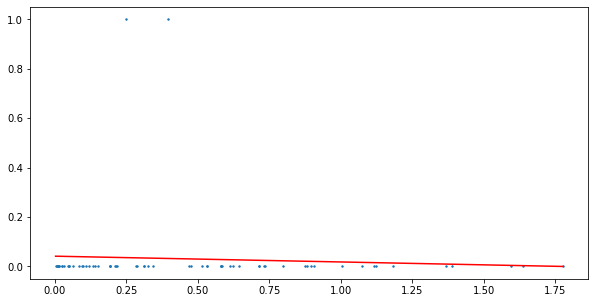

user id: 77, a: -0.00, b:0.03, length: 81


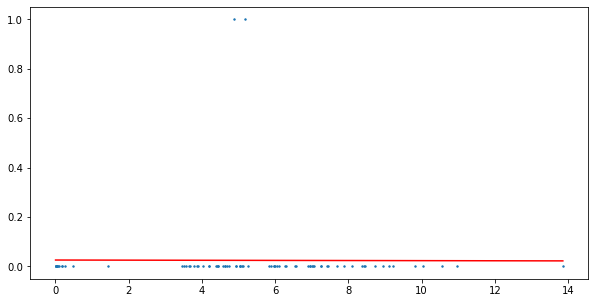

user id: 372, a: 0.47, b:-0.05, length: 45


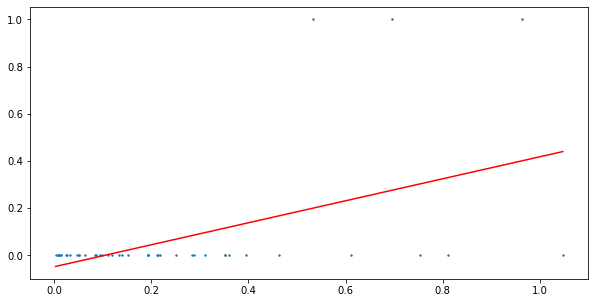

user id: 203, a: 0.19, b:0.01, length: 37


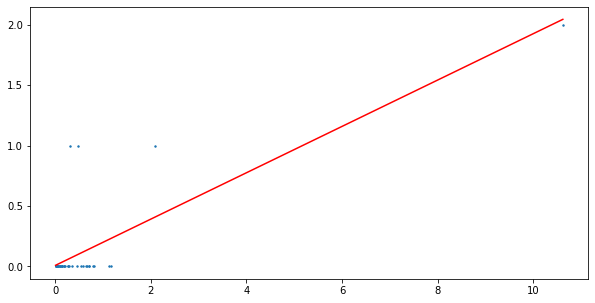

user id: 320, a: 0.39, b:-0.02, length: 36


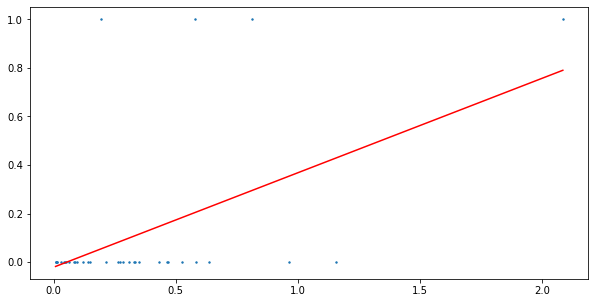

user id: 229, a: 0.40, b:0.04, length: 28


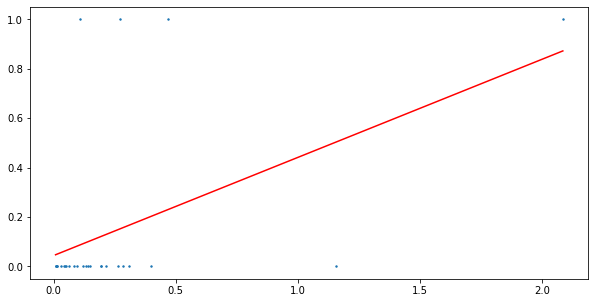

user id: 1950, a: 0.20, b:-0.02, length: 56


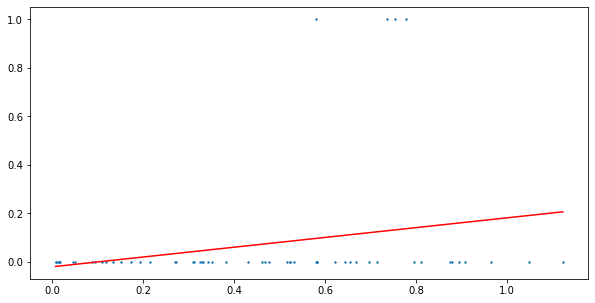

user id: 1356, a: 0.48, b:-0.06, length: 42


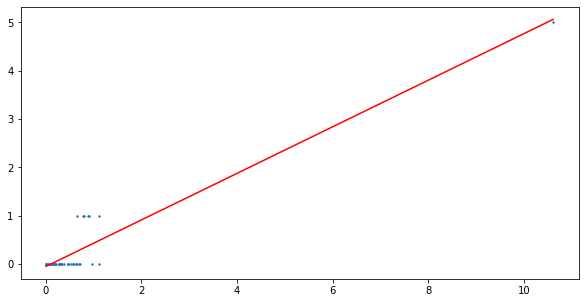

user id: 1884, a: 0.23, b:-0.03, length: 68


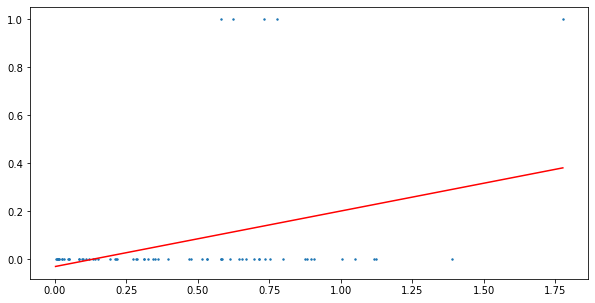

user id: 1276, a: 0.17, b:0.08, length: 36


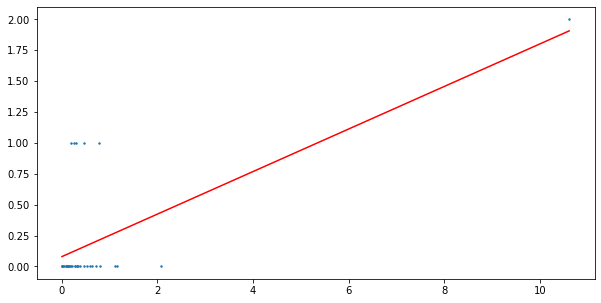

user id: 1999, a: -0.01, b:0.09, length: 35


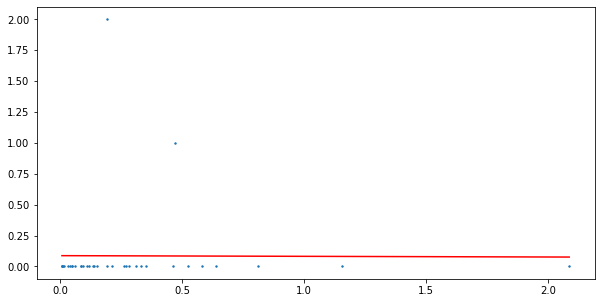

user id: 338, a: 0.96, b:-0.18, length: 37


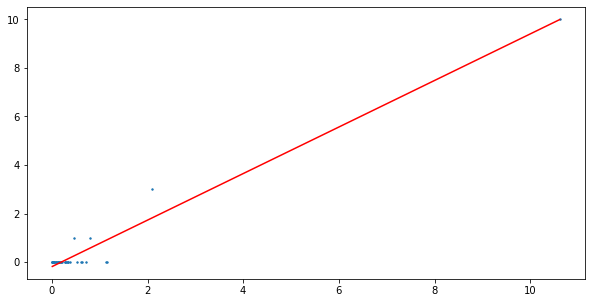

In [254]:
for row in top_fit.iterrows():
    print("user id: %d, a: %.2f, b:%.2f, length: %d"%(row[1].user_id,row[1].a,row[1].b,row[1].length))
    uid = row[1].user_id
    x = retry_dedup.loc[retry_dedup.user_id==uid].global_retrytime.to_numpy()
    y = retry_dedup.loc[retry_dedup.user_id==uid].retry_time.to_numpy()
    plot_linear(x,y,row[1].a,row[1].b)

3.2 用前后k关对retry time做平滑，再进行fit

In [407]:
Neighbor = 5

In [438]:
uidlist, alist, blist, selist,lenlist, selist_all = [],[],[],[],[],[]
for uid in tqdm(set(retry_dedup.user_id.tolist())):
    uidlist.append(uid)
    x = retry_dedup.loc[retry_dedup.user_id==uid].global_retrytime.to_numpy()
    y = retry_dedup.loc[retry_dedup.user_id==uid].retry_time.to_numpy()
    y_cum = y.cumsum()
    y_smooth = np.array([(y_cum[min(i+Neighbor,len(y)-1)]-y_cum[max(i-Neighbor,0)])/(2*Neighbor+1) for i in range(len(y))])

    A = np.vstack([x,np.ones(len(x))]).T
    results = np.linalg.lstsq(A,y_smooth, rcond=None)
    alist.append(results[0][0])
    blist.append(results[0][1])
    selist.append(results[1][0]/len(x))
    selist_all.append(results[1][0])
    lenlist.append(len(x))
fit_results = pd.DataFrame(np.array([uidlist, alist, blist, selist,lenlist,selist_all]).T,
                           columns=["user_id","a","b","s_e","length","s_e_all"])


In [439]:
# Neighbor=5
fit_results.corr()

,user_id,a,b,s_e,length,s_e_all
user_id,1.000000,0.051763,-0.013021,0.004102,-0.011741,-0.000249
a,0.051763,1.000000,-0.038697,0.426924,0.067027,0.289786
b,-0.013021,-0.038697,1.000000,0.451697,0.198118,0.311788
s_e,0.004102,0.426924,0.451697,1.000000,0.464966,0.833335
length,-0.011741,0.067027,0.198118,0.464966,1.000000,0.719340
s_e_all,-0.000249,0.289786,0.311788,0.833335,0.719340,1.000000


In [410]:
# Neighbor=5
fit_results.describe()

,user_id,a,b,s_e,length,s_e_all
count,1896.000000,1896.000000,1896.000000,1896.000000,1896.000000,1896.000000
mean,1000.214135,0.483892,0.467548,1.169218,223.213080,370.502753
std,575.232646,0.303669,0.517272,1.384196,170.253513,630.081767
min,1.000000,-0.365063,-1.053968,0.000000,8.000000,0.000000
25%,505.750000,0.289215,0.148437,0.232551,114.000000,27.656752
50%,1006.500000,0.442398,0.353165,0.698497,161.000000,121.275403
75%,1493.250000,0.616443,0.663596,1.601945,282.000000,438.616082
max,2000.000000,3.621707,4.941539,12.668188,962.000000,8026.179593


Text(0.5, 0, 'a')

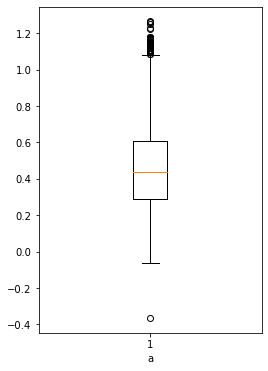

In [451]:
plt.figure(figsize=(4,6))
plt.boxplot(sorted(fit_results.a.tolist())[:-30],meanline=True)#,showfliers=False)
plt.xlabel("a")

In [411]:
import random
random_uid = (fit_results.user_id.tolist())
random.shuffle(random_uid)

user id: 1690, a: 0.38, b:-0.15, length: 115


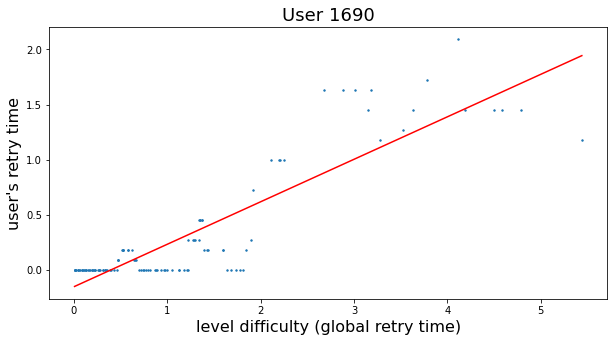

user id: 832, a: 0.47, b:0.44, length: 208


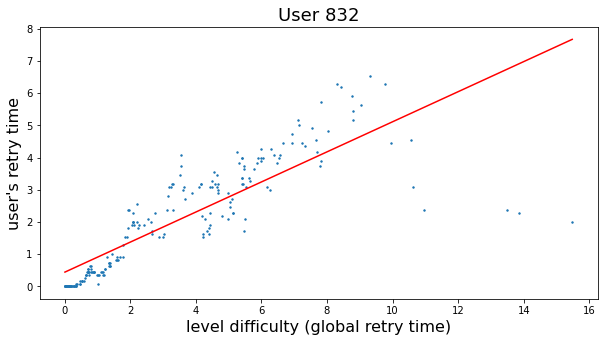

user id: 1203, a: 0.22, b:0.02, length: 134


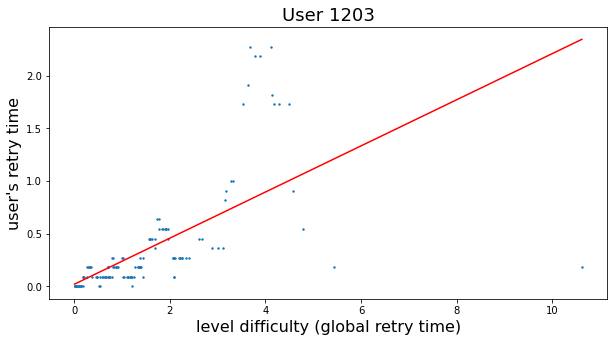

user id: 58, a: 0.21, b:0.79, length: 152


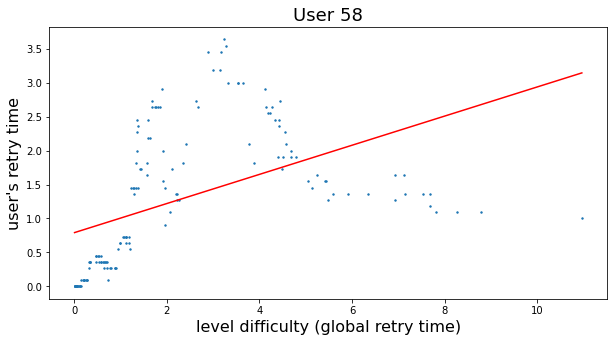

user id: 874, a: 0.70, b:0.61, length: 311


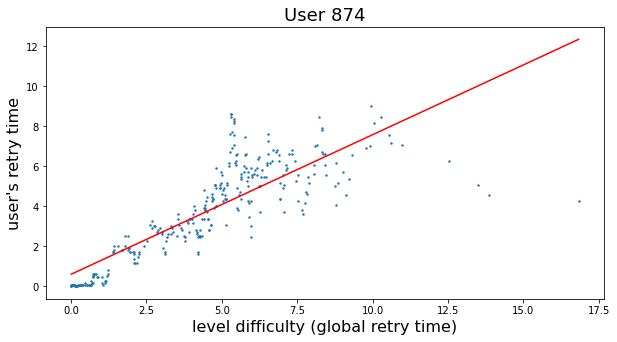

user id: 1805, a: 0.20, b:0.16, length: 98


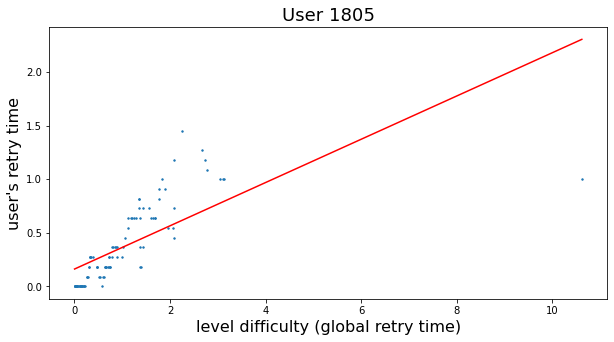

user id: 1316, a: 0.52, b:0.35, length: 332


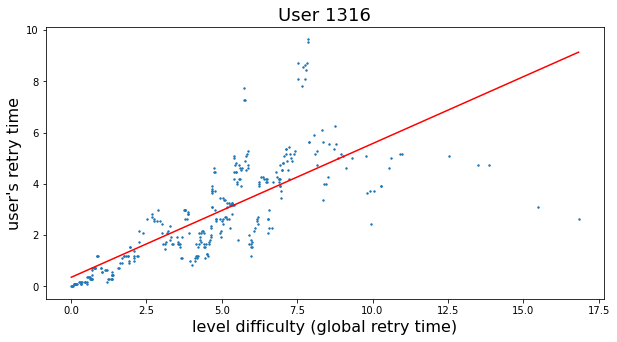

user id: 1427, a: 1.10, b:0.46, length: 94


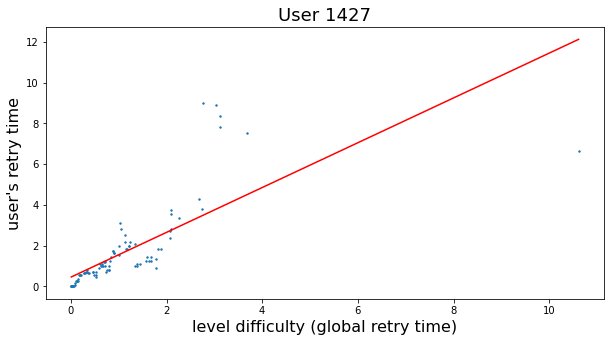

user id: 1960, a: 1.01, b:0.04, length: 24


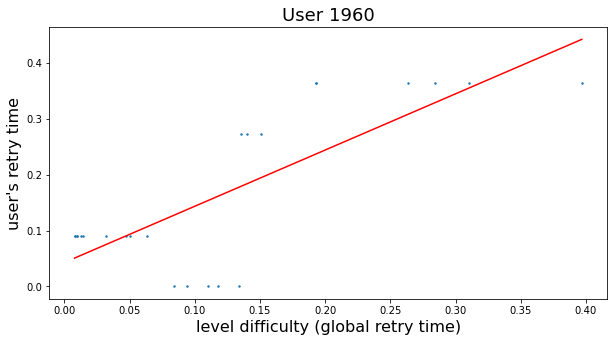

user id: 232, a: 0.22, b:0.63, length: 175


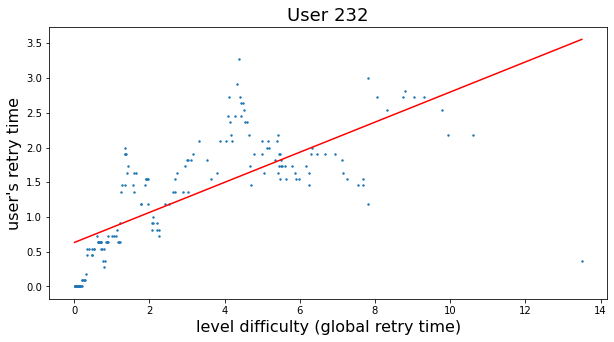

In [413]:
for uid in random_uid[:10]:
    row = fit_results.loc[fit_results.user_id==uid]
    print("user id: %d, a: %.2f, b:%.2f, length: %d"%(row.user_id,row.a,row.b,row.length))
    x = retry_dedup.loc[retry_dedup.user_id==uid].global_retrytime.to_numpy()
    y = retry_dedup.loc[retry_dedup.user_id==uid].retry_time.to_numpy()
    y_cum = y.cumsum()
    y_smooth = np.array([(y_cum[min(i+Neighbor,len(y)-1)]-y_cum[max(i-Neighbor,0)])/(2*Neighbor+1) for i in range(len(y))])

    plot_linear(x,y_smooth,row.a.iloc[0],row.b.iloc[0],uid=uid)

user id: 514, a: 0.85, b:2.52, length: 259


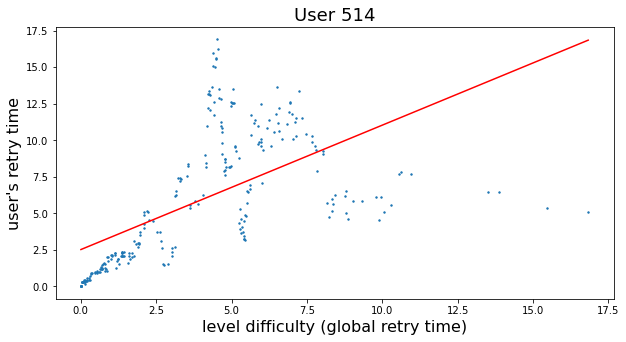

In [423]:
uid = 514
row = fit_results.loc[fit_results.user_id==uid]
print("user id: %d, a: %.2f, b:%.2f, length: %d"%(row.user_id,row.a,row.b,row.length))
x = retry_dedup.loc[retry_dedup.user_id==uid].global_retrytime.to_numpy()
y = retry_dedup.loc[retry_dedup.user_id==uid].retry_time.to_numpy()
y_cum = y.cumsum()
y_smooth = np.array([(y_cum[min(i+Neighbor,len(y)-1)]-y_cum[max(i-Neighbor,0)])/(2*Neighbor+1) for i in range(len(y))])

plot_linear(x,y_smooth,row.a.iloc[0],row.b.iloc[0],uid=uid)

In [414]:
top_fit = fit_results.sort_values(by="s_e").head(20)
worst_fit = fit_results.sort_values(by="s_e").tail(20)

user id: 1122, a: 0.00, b:0.00, length: 93


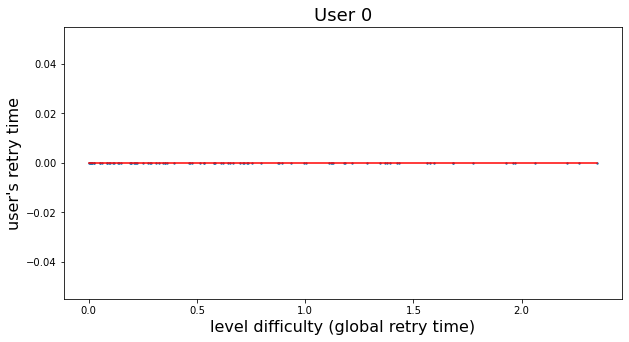

user id: 1492, a: -0.00, b:0.09, length: 16


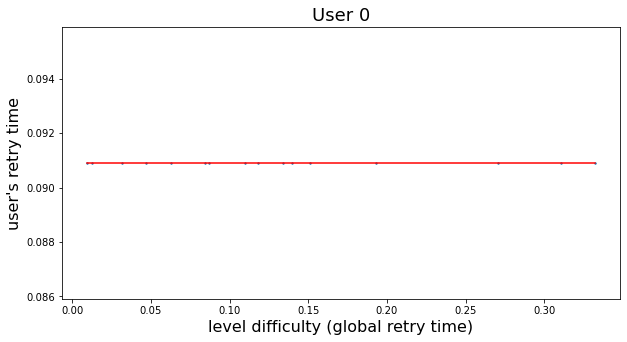

user id: 198, a: 0.05, b:-0.01, length: 31


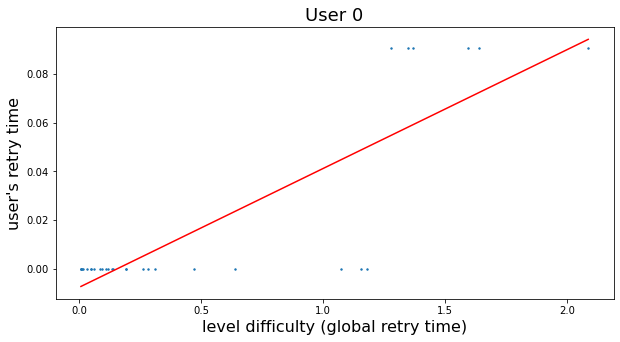

user id: 1966, a: 0.10, b:0.00, length: 22


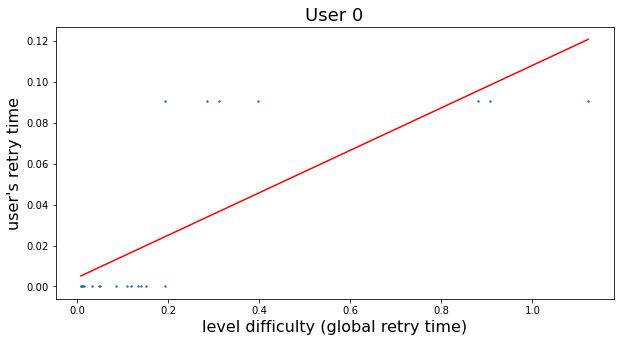

user id: 1502, a: 0.07, b:0.01, length: 44


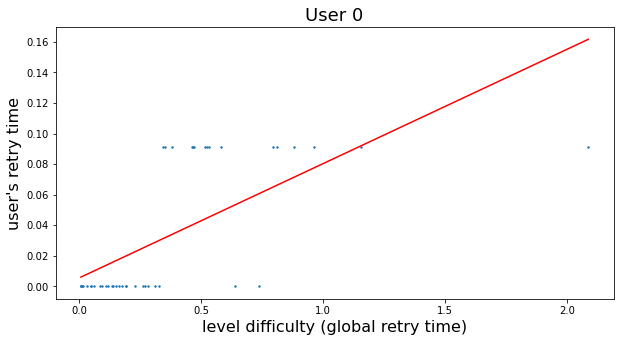

user id: 411, a: 0.02, b:0.01, length: 44


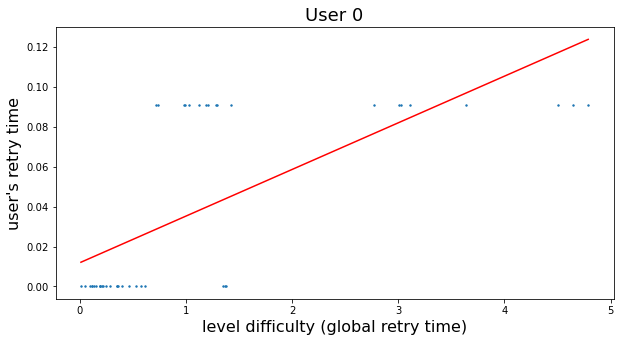

user id: 1804, a: 0.06, b:0.02, length: 26


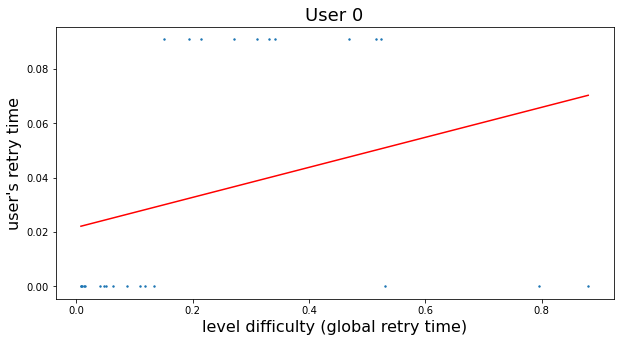

user id: 77, a: -0.00, b:0.02, length: 81


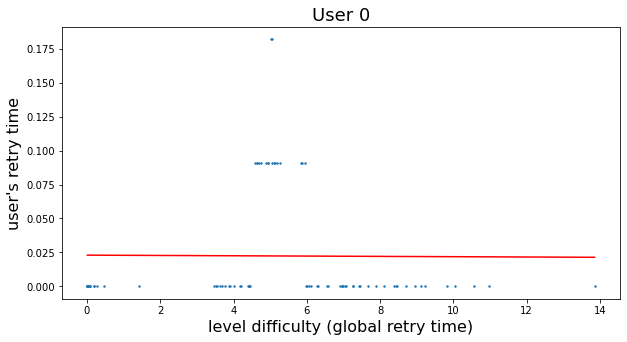

user id: 369, a: 0.07, b:0.03, length: 34


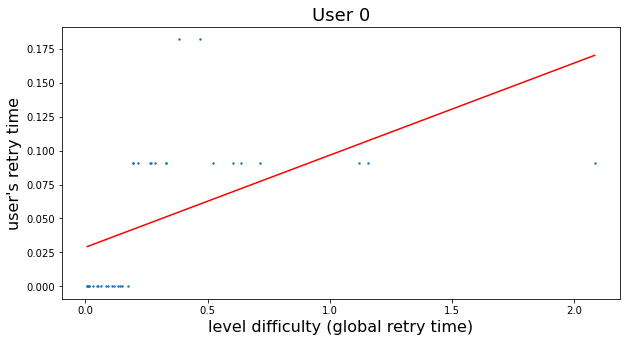

user id: 29, a: -0.02, b:0.04, length: 67


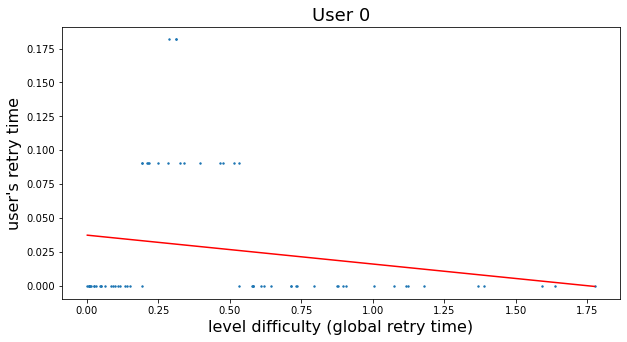

user id: 372, a: 0.31, b:-0.02, length: 45


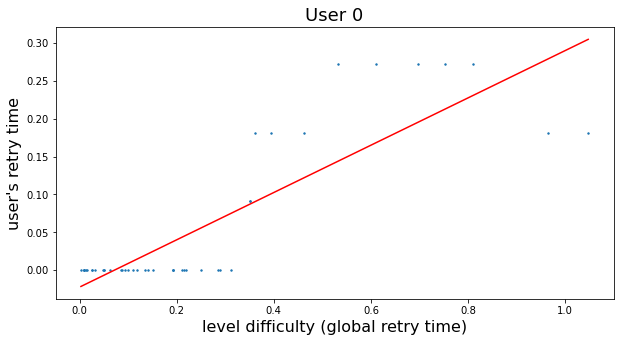

user id: 1884, a: 0.13, b:0.00, length: 68


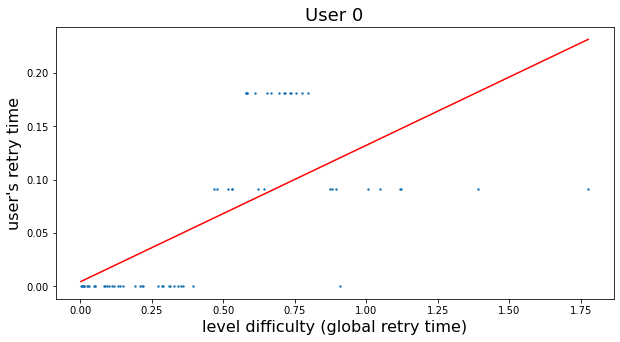

user id: 515, a: 0.26, b:0.01, length: 38


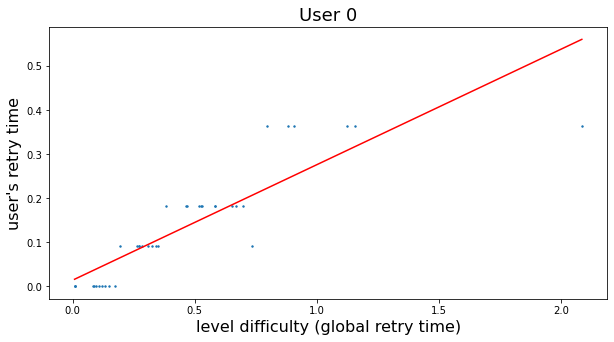

user id: 1984, a: 0.53, b:0.00, length: 36


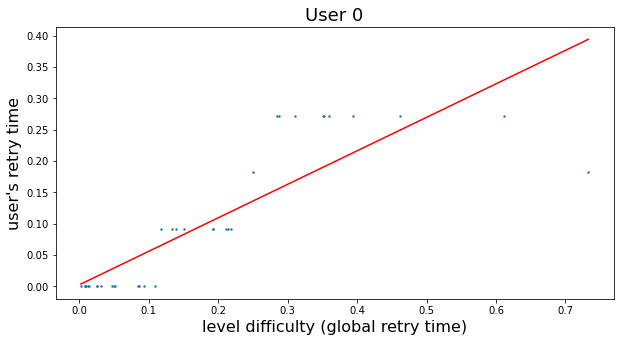

user id: 320, a: 0.15, b:0.04, length: 36


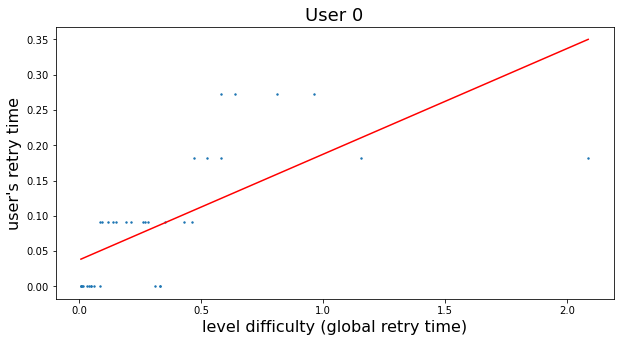

user id: 1644, a: 0.23, b:-0.04, length: 81


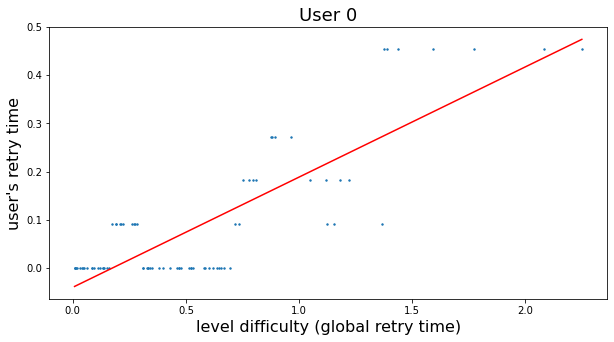

user id: 229, a: 0.10, b:0.09, length: 28


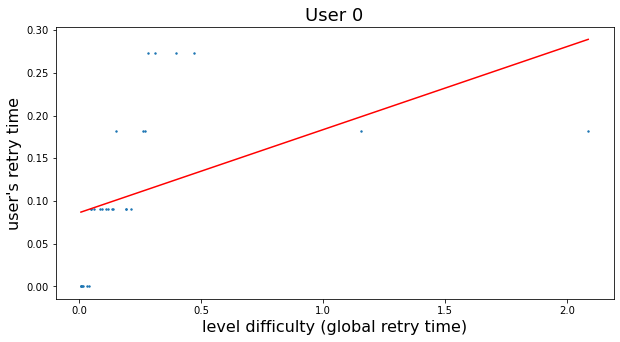

user id: 1950, a: 0.17, b:-0.01, length: 56


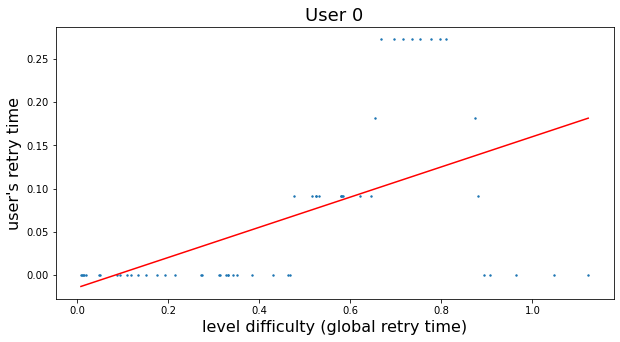

user id: 1999, a: -0.00, b:0.08, length: 35


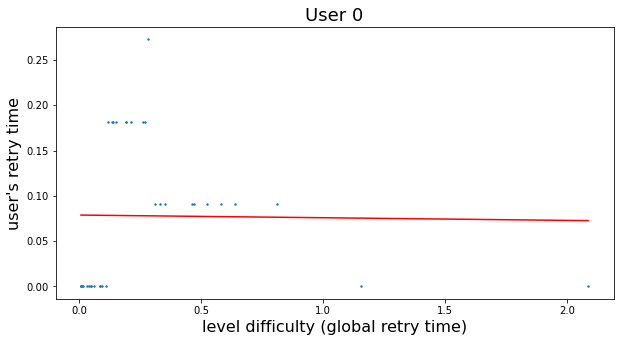

user id: 1576, a: 0.02, b:0.09, length: 44


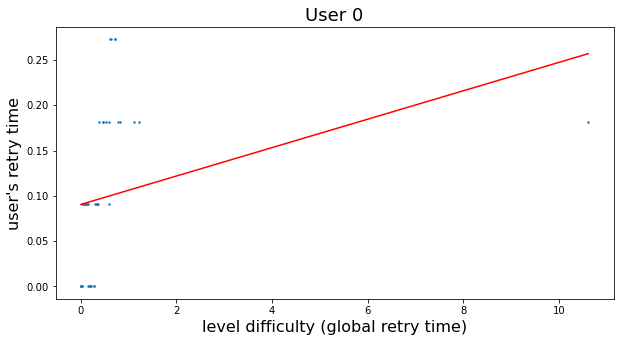

In [415]:
for row in top_fit.iterrows():
    print("user id: %d, a: %.2f, b:%.2f, length: %d"%(row[1].user_id,row[1].a,row[1].b,row[1].length))
    uid = row[1].user_id
    x = retry_dedup.loc[retry_dedup.user_id==uid].global_retrytime.to_numpy()
    y = retry_dedup.loc[retry_dedup.user_id==uid].retry_time.to_numpy()
    y_cum = y.cumsum()
    y_smooth = np.array([(y_cum[min(i+Neighbor,len(y)-1)]-y_cum[max(i-Neighbor,0)])/(2*Neighbor+1) for i in range(len(y))])

    plot_linear(x,y_smooth,row[1].a,row[1].b)

user id: 1499, a: 0.73, b:0.57, length: 693, average se: 6.434


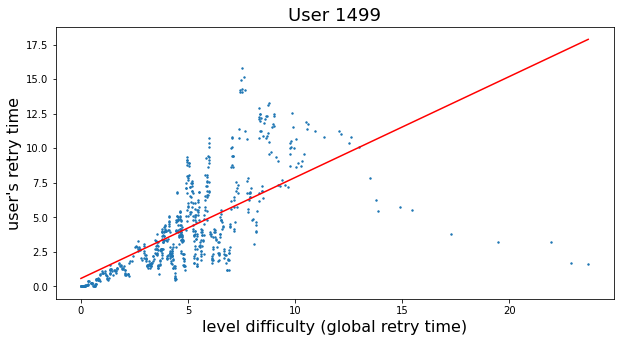

user id: 1846, a: 0.88, b:1.35, length: 442, average se: 6.571


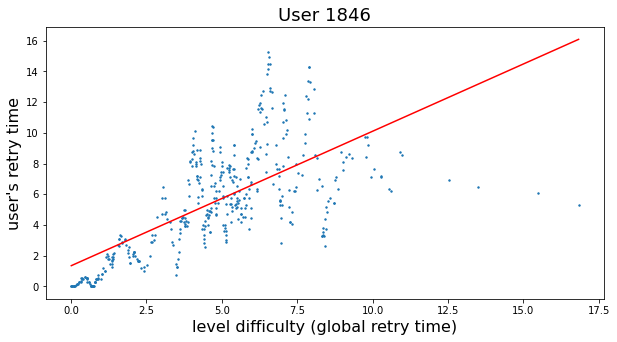

user id: 854, a: 0.06, b:3.57, length: 28, average se: 6.645


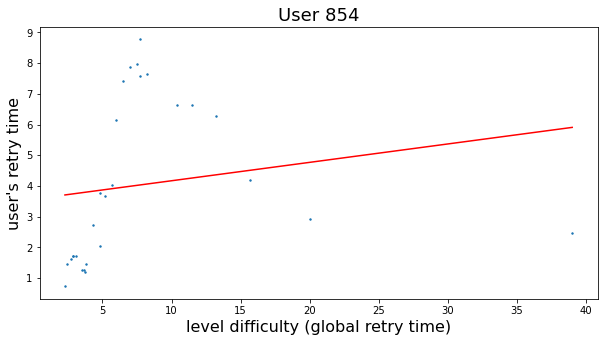

user id: 555, a: 0.76, b:0.94, length: 184, average se: 6.780


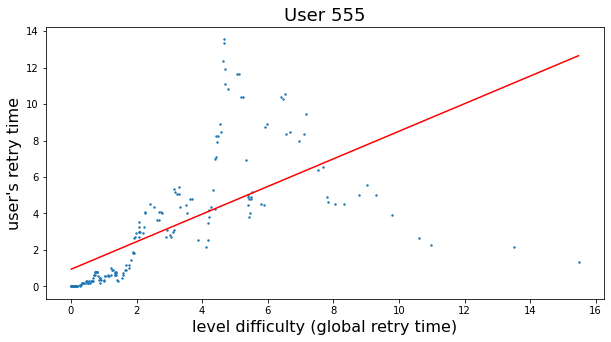

user id: 1726, a: 0.38, b:4.93, length: 134, average se: 6.789


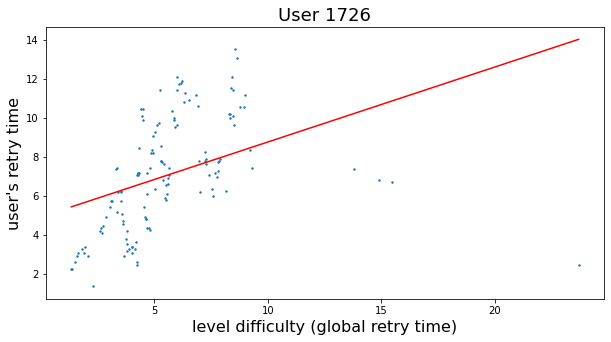

user id: 239, a: 1.10, b:1.23, length: 427, average se: 6.925


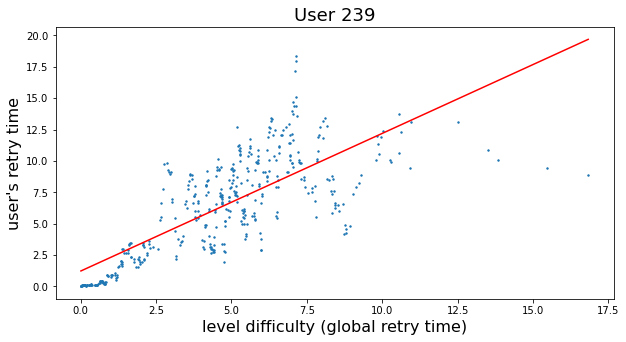

user id: 466, a: 0.67, b:2.01, length: 555, average se: 6.988


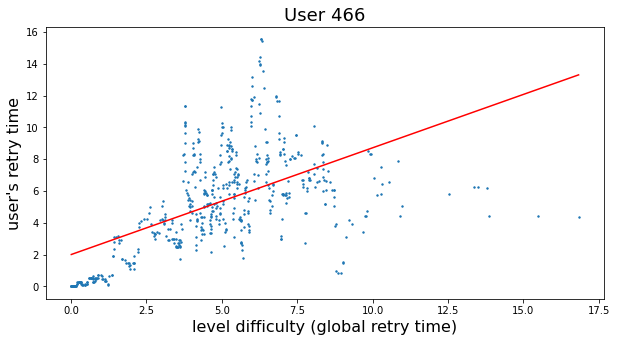

user id: 1053, a: 1.11, b:1.95, length: 147, average se: 7.173


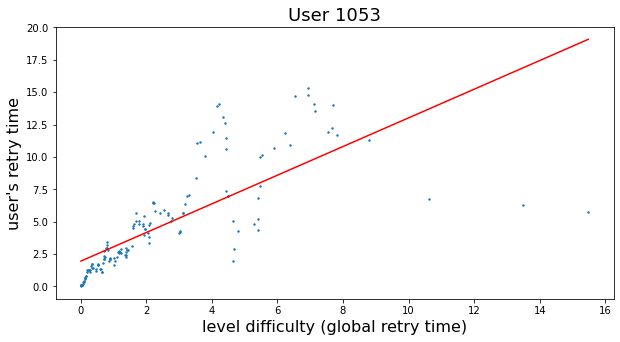

user id: 230, a: 0.83, b:0.71, length: 225, average se: 7.705


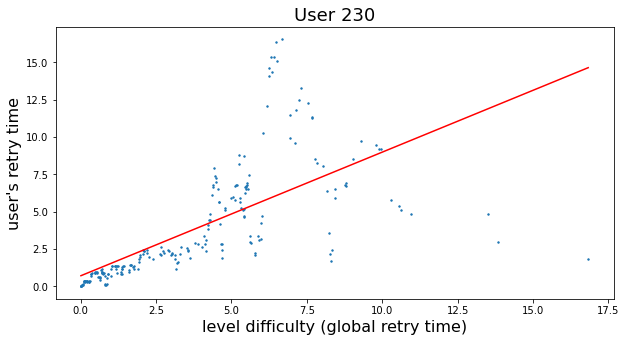

user id: 1664, a: 0.45, b:1.09, length: 57, average se: 7.909


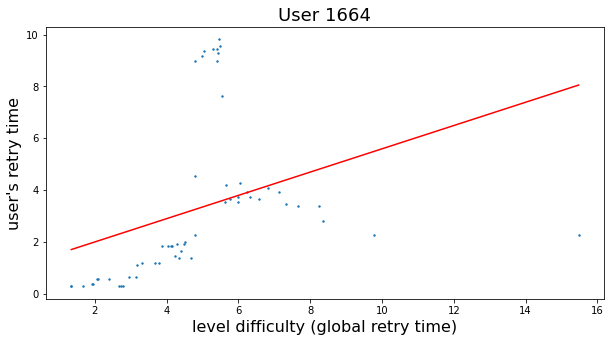

user id: 1446, a: 0.87, b:2.84, length: 264, average se: 8.209


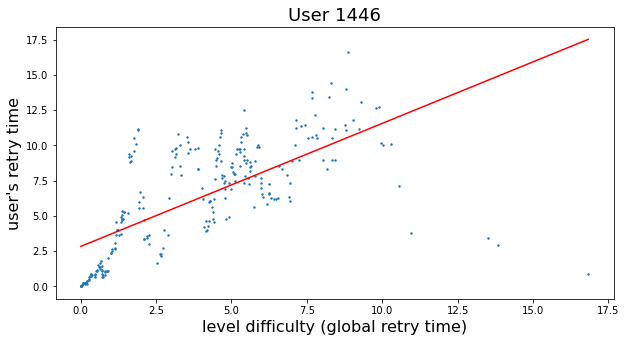

user id: 1853, a: 0.82, b:1.93, length: 268, average se: 8.417


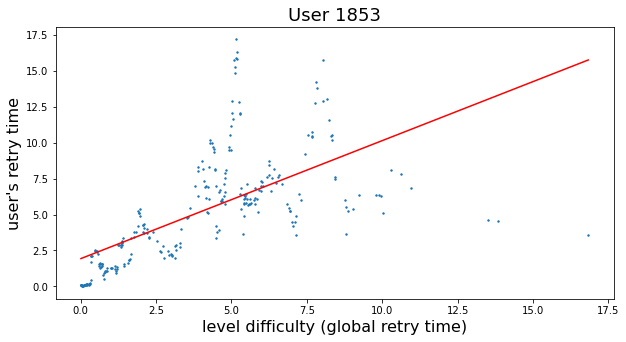

user id: 195, a: 1.13, b:0.33, length: 822, average se: 8.598


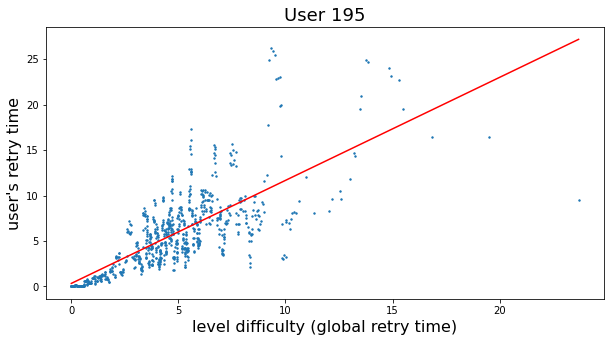

user id: 1003, a: 0.81, b:1.31, length: 337, average se: 8.682


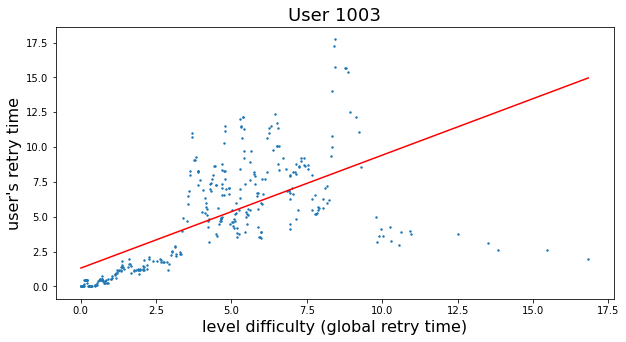

user id: 655, a: 1.03, b:1.52, length: 270, average se: 9.297


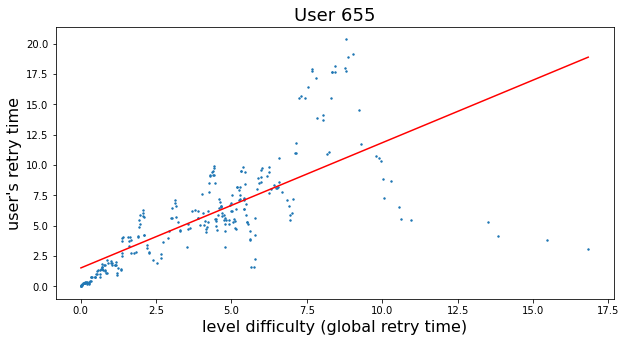

user id: 546, a: 2.41, b:1.98, length: 111, average se: 9.326


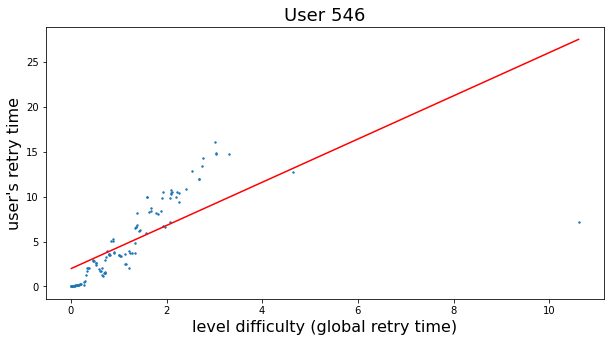

user id: 1929, a: 1.11, b:1.40, length: 786, average se: 10.211


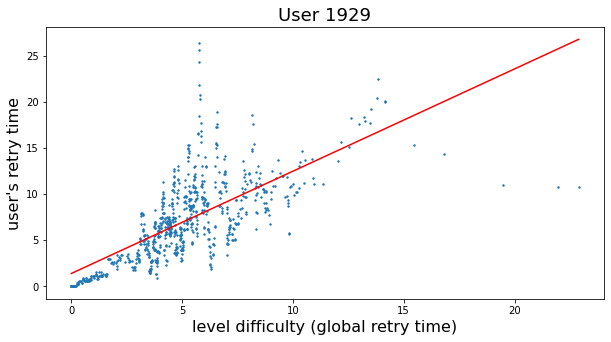

user id: 915, a: 1.00, b:0.52, length: 331, average se: 11.147


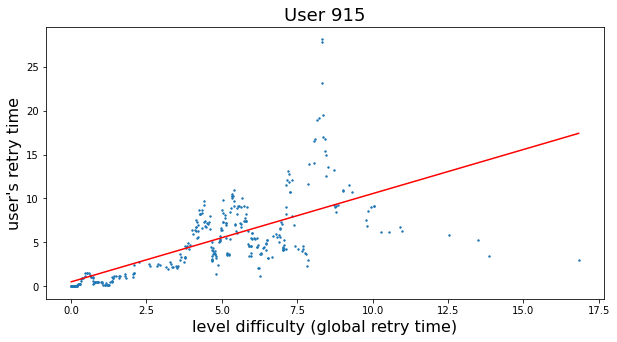

user id: 784, a: 0.84, b:1.87, length: 513, average se: 11.494


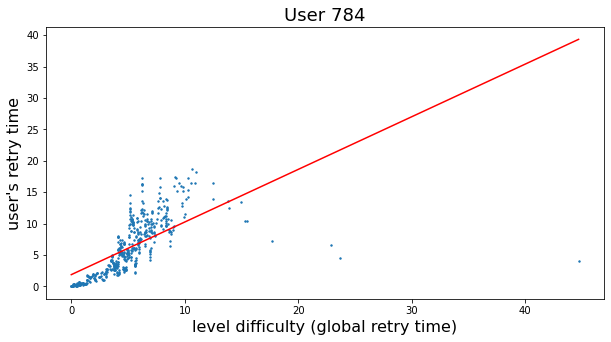

user id: 514, a: 0.85, b:2.52, length: 259, average se: 12.668


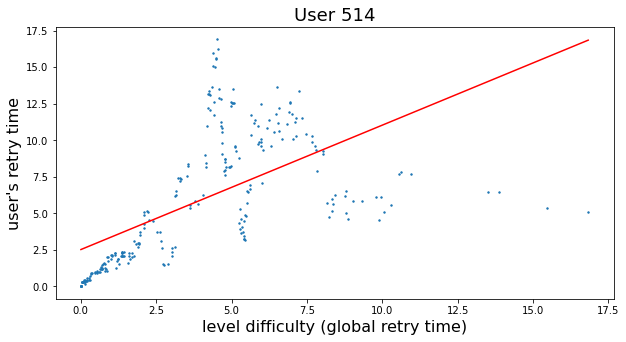

In [417]:
for row in worst_fit.iterrows():
    print("user id: %d, a: %.2f, b:%.2f, length: %d, average se: %.3f"%(row[1].user_id,row[1].a,row[1].b,row[1].length,row[1].s_e))
    uid = row[1].user_id
    x = retry_dedup.loc[retry_dedup.user_id==uid].global_retrytime.to_numpy()
    y = retry_dedup.loc[retry_dedup.user_id==uid].retry_time.to_numpy()
    k = 4
    y_cum = y.cumsum()
    y_smooth = np.array([(y_cum[min(i+Neighbor,len(y)-1)]-y_cum[max(i-Neighbor,0)])/(2*Neighbor+1) for i in range(len(y))])

    plot_linear(x,y_smooth,row[1].a,row[1].b,uid)

3.3 平滑后，不用线性关系，而是用线性+sin函数的形式

y = ax+b+c*sin(x/t+d)

In [425]:
def plot_curve(x,y, curve, params=[],savefig=False,uid=0,filename=""):
    # scatter original data, plot the linear ax+b
    plt.figure(figsize=(10,5))
    ax = plt.subplot()
    ax.scatter(x,y,s=2)
    ax.plot(x,curve(x,params[0],params[1],params[2],params[3],params[4]),color='r')
    ax.set_xlabel("level difficulty (global retry time)",fontsize=16)
    ax.set_ylabel("user's retry time",fontsize=16)
    ax.set_title("User %d"%(uid),fontsize=18)
    if savefig:
        plt.savefig("figures/"+filename)
    plt.show()

In [426]:
Neighbor = 5

In [329]:
# 比v2好，比v1差, se均值0.986999
def curve_fun(x, a,b,c,d,t):
    return a*x+c*np.sin(x+d)+b

In [434]:
# 最佳，se均值0.850452
def curve_fun_v1(x, a,b,c,d,t):
    return a*x+c*np.sin(x*t+d)+b

In [326]:
# 最差，se均值1.10321
def curve_fun_v2(x, a,b,c,d):
    return a*x+c*x*np.sin(x+d)+b

In [335]:
# 比v1稍差，se均值8.838010e-01
def curve_fun_v3(x, a,b,c,d,t):
    return a*x+c*x*np.sin(x*t+d)+b

In [435]:
uidlist, selist,lenlist, selist_all = [],[],[],[]
params = []
for uid in tqdm(set(retry_dedup.user_id.tolist())):
    uidlist.append(uid)
    x = retry_dedup.loc[retry_dedup.user_id==uid].global_retrytime.to_numpy()
    y = retry_dedup.loc[retry_dedup.user_id==uid].retry_time.to_numpy()
    y_cum = y.cumsum()
    y_smooth = np.array([(y_cum[min(i+Neighbor,len(y)-1)]-y_cum[max(i-Neighbor,0)])/(2*Neighbor+1) for i in range(len(y))])

    #results = scipy.optimize.curve_fit(curve_fun, x, y_smooth,maxfev=1000,p0=[1,0,1,0])
    results = scipy.optimize.curve_fit(curve_fun_v1, x, y_smooth,maxfev=100000,p0=[1,0,1,0,1])
    #results = scipy.optimize.curve_fit(curve_fun_v2, x, y_smooth,maxfev=1000,p0=[1,0,1,0])
    #results = scipy.optimize.curve_fit(curve_fun_v3, x, y_smooth,maxfev=100000,p0=[1,0,1,0,1])
    params.append(results[0])
    
    #y_pred = curve_fun(x,results[0][0],results[0][1],results[0][2],results[0][3])
    y_pred = curve_fun_v1(x,results[0][0],results[0][1],results[0][2],results[0][3],results[0][4])
    #y_pred = curve_fun_v2(x,results[0][0],results[0][1],results[0][2],results[0][3])
    #y_pred = curve_fun_v3(x,results[0][0],results[0][1],results[0][2],results[0][3],results[0][4])
    se_all = ((y_pred-y_smooth)**2).sum()
    selist.append(se_all/len(y))
    selist_all.append(se_all)
    lenlist.append(len(x))
fit_results_sin = pd.DataFrame(np.array([uidlist,selist,lenlist,selist_all]).T,
                           columns=["user_id","s_e","length","s_e_all"])


/work/lijiayu/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/work/lijiayu/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [452]:
params_all = np.array(params)

In [453]:
for i in range(params_all.shape[1]):
    fit_results_sin["param"+str(i)] = params_all[:,i]

In [455]:
# Neighbor=5 
# y = ax+b+c*sin(x*t+d)
fit_results_sin.describe()

,user_id,s_e,length,s_e_all,param0,param1,param2,param3,param4
count,1896.000000,1896.000000,1896.000000,1896.000000,1896.000000,1896.000000,1896.000000,1896.000000,1896.000000
mean,1000.214135,0.850452,223.213080,296.736059,-3.610156,-17.364928,442.623054,0.433597,1.045470
std,575.232646,1.157062,170.253513,567.978384,128.148501,234.231278,2637.739921,3.078323,1.408697
min,1.000000,0.000000,8.000000,0.000000,-1858.253376,-2741.039321,-22219.943557,-16.073282,-6.797665
25%,505.750000,0.119946,114.000000,14.309502,0.057412,0.167862,-0.759918,-1.652592,0.319074
50%,1006.500000,0.407741,161.000000,68.582752,0.260679,0.699998,0.393903,0.210814,0.835905
75%,1493.250000,1.157011,282.000000,327.482811,0.541036,1.500476,1.270166,2.025807,1.362616
max,2000.000000,11.329379,962.000000,7097.062765,2526.001226,2519.991441,34827.815552,15.678289,23.102987


In [456]:
fit_results_sin.corr()

,user_id,s_e,length,s_e_all,param0,param1,param2,param3,param4
user_id,1.000000,0.002958,-0.011741,-0.002356,-0.018824,0.028615,0.046147,-0.019514,0.022686
s_e,0.002958,1.000000,0.542963,0.879914,0.002892,0.048259,-0.039572,-0.076106,-0.022458
length,-0.011741,0.542963,1.000000,0.712977,0.001890,0.007954,-0.107632,0.099994,-0.154012
s_e_all,-0.002356,0.879914,0.712977,1.000000,0.001999,0.035072,-0.048889,-0.040844,-0.031206
param0,-0.018824,0.002892,0.001890,0.001999,1.000000,-0.685716,-0.206030,0.067958,0.027728
param1,0.028615,0.048259,0.007954,0.035072,-0.685716,1.000000,0.046358,-0.141529,0.054709
param2,0.046147,-0.039572,-0.107632,-0.048889,-0.206030,0.046358,1.000000,0.055299,-0.118978
param3,-0.019514,-0.076106,0.099994,-0.040844,0.067958,-0.141529,0.055299,1.000000,-0.458906
param4,0.022686,-0.022458,-0.154012,-0.031206,0.027728,0.054709,-0.118978,-0.458906,1.000000


In [457]:
top_fit = fit_results_sin.sort_values(by="s_e").head(20)
worst_fit = fit_results_sin.sort_values(by="s_e").tail(20)

user id: 1122, length: 93
0.00*x+-0.00*sin(x*-0.00+-0.00)+1.00


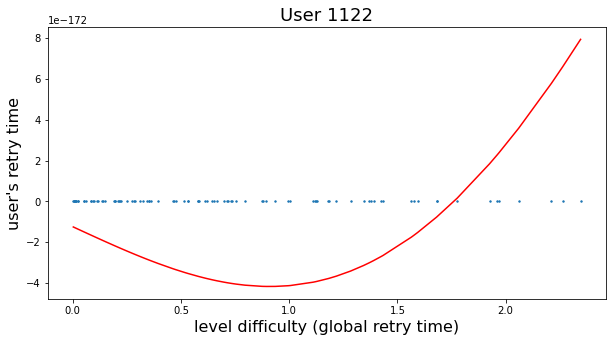

user id: 1492, length: 16
-0.00*x+0.09*sin(x*0.00+-0.00)+0.35


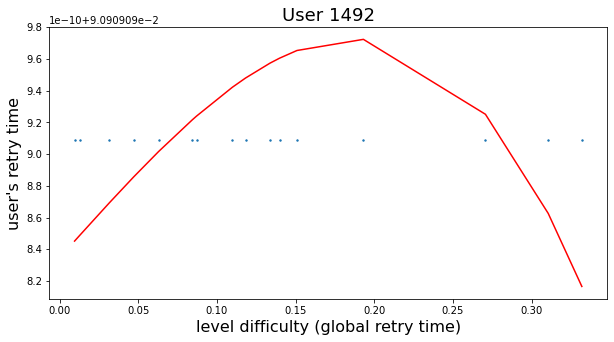

user id: 198, length: 31
0.07*x+-0.04*sin(x*-0.04+-1.90)+4.11


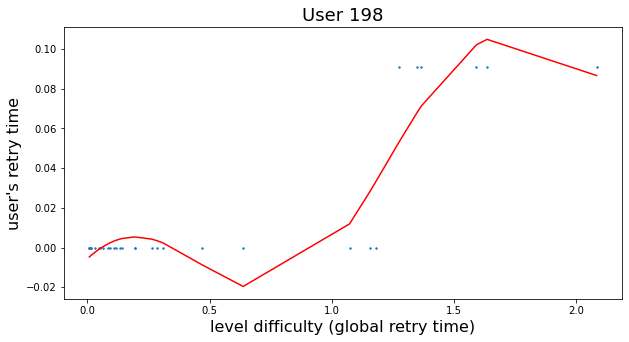

user id: 1966, length: 22
0.08*x+0.05*sin(x*0.06+-1.89)+6.34


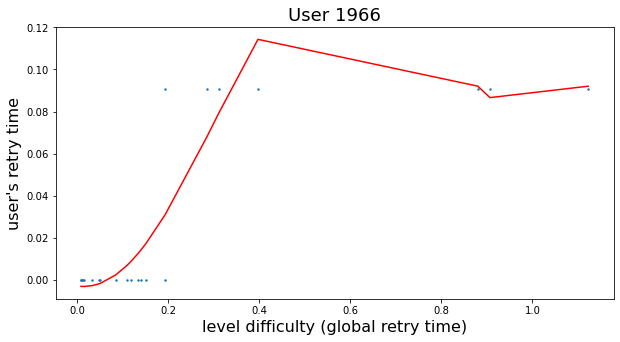

user id: 372, length: 45
0.22*x+0.05*sin(x*0.10+-2.78)+7.00


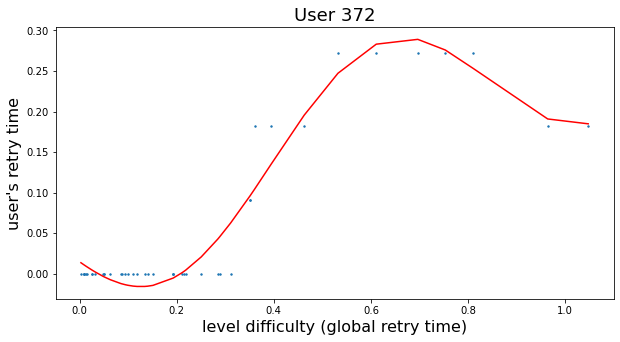

user id: 1804, length: 26
-0.01*x+0.05*sin(x*0.06+-1.36)+8.06


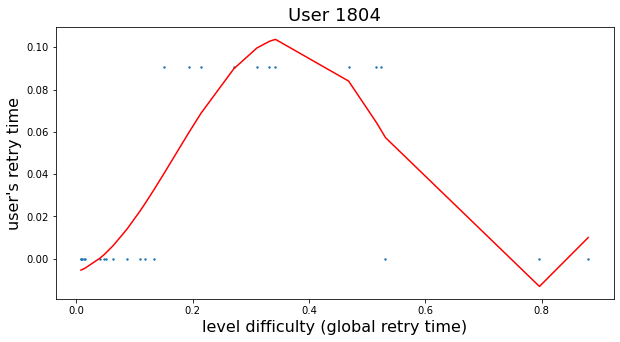

user id: 1984, length: 36
0.26*x+0.09*sin(x*0.10+-1.98)+8.58


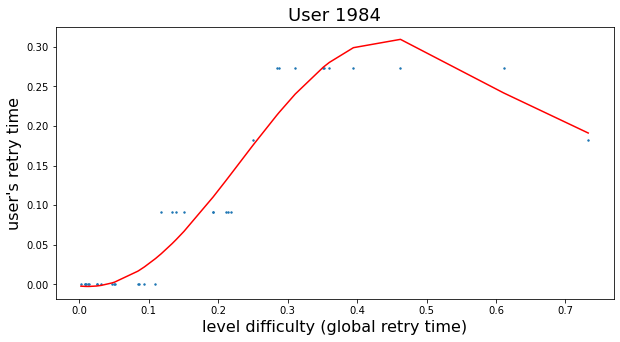

user id: 411, length: 44
1.25*x+-4.08*sin(x*10.15+2.73)+0.12


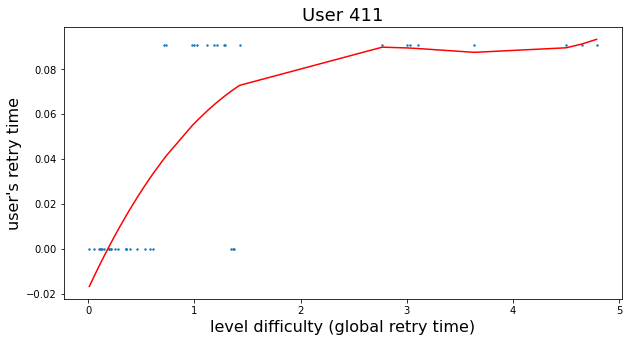

user id: 1502, length: 44
0.04*x+0.02*sin(x*0.04+-1.00)+3.42


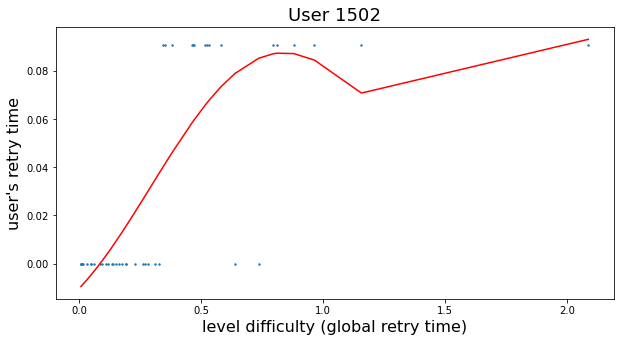

user id: 369, length: 34
0.73*x+-0.77*sin(x*0.78+1.85)+1.11


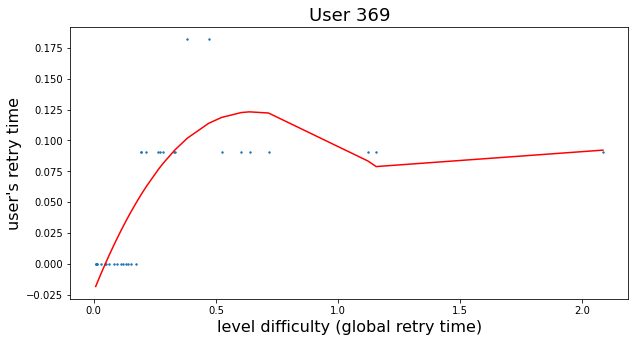

user id: 1884, length: 68
0.07*x+0.04*sin(x*-0.07+2.93)+-6.80


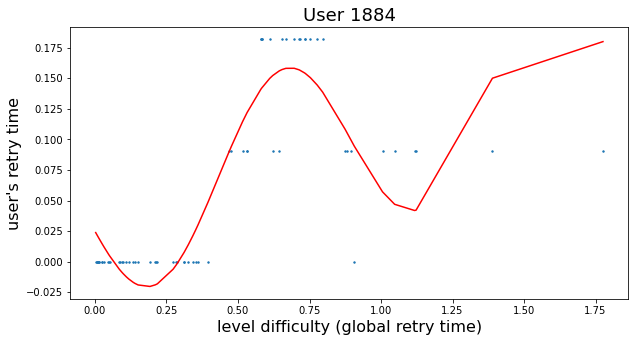

user id: 29, length: 67
-0.06*x+0.07*sin(x*-0.06+1.25)+9.60


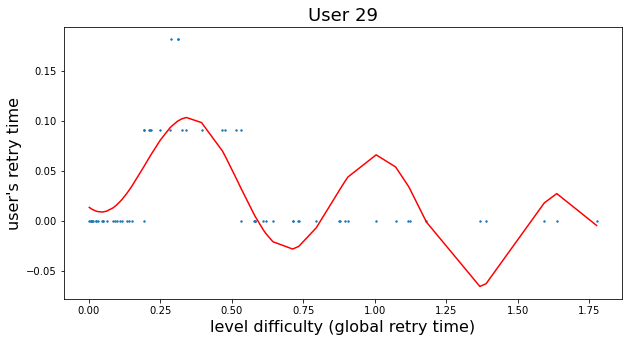

user id: 77, length: 81
0.00*x+0.00*sin(x*-0.05+-0.15)+0.94


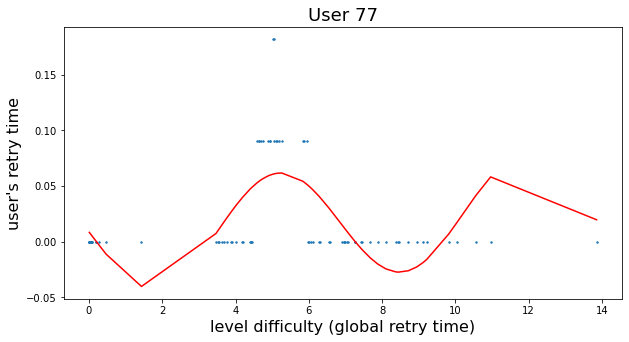

user id: 229, length: 28
0.16*x+-0.00*sin(x*0.23+0.02)+2.68


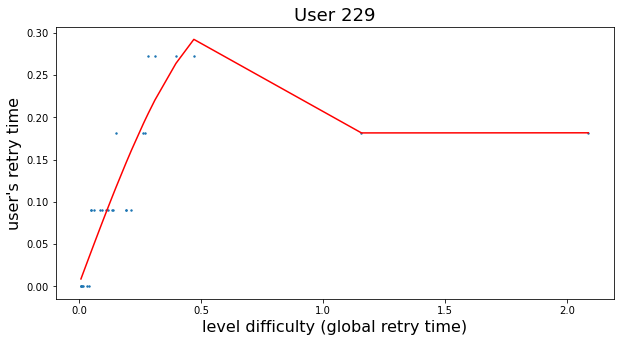

user id: 515, length: 38
-14.61*x+6.99*sin(x*76.80+-0.09)+0.20


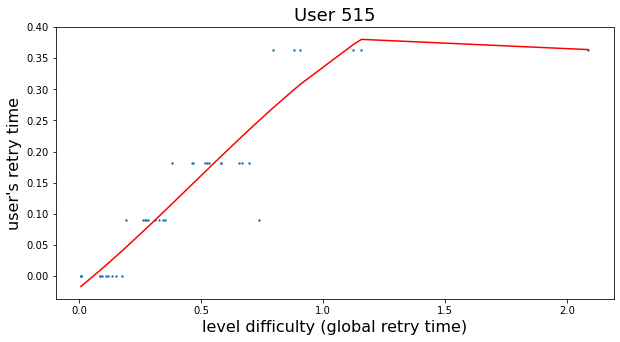

user id: 320, length: 36
0.02*x+0.14*sin(x*-0.12+1.77)+-3.89


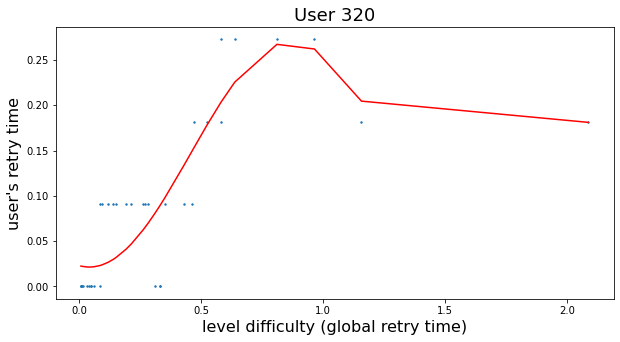

user id: 630, length: 30
0.04*x+0.18*sin(x*-0.19+-5.25)+7.17


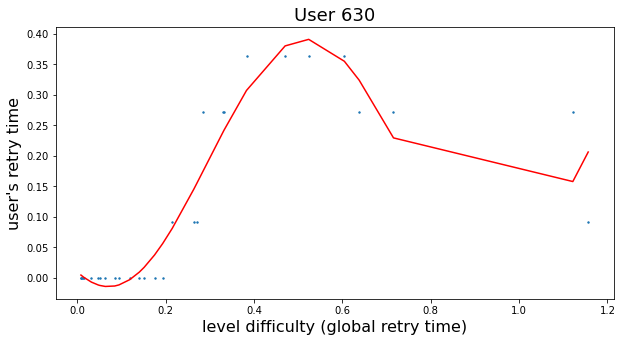

user id: 925, length: 71
0.01*x+0.17*sin(x*-0.19+-4.10)+-0.98


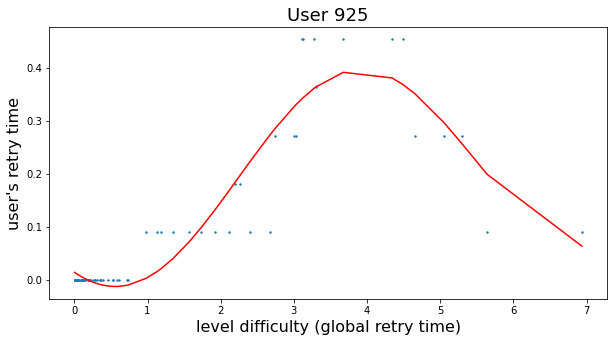

user id: 1576, length: 44
0.01*x+0.14*sin(x*0.10+-1.85)+4.12


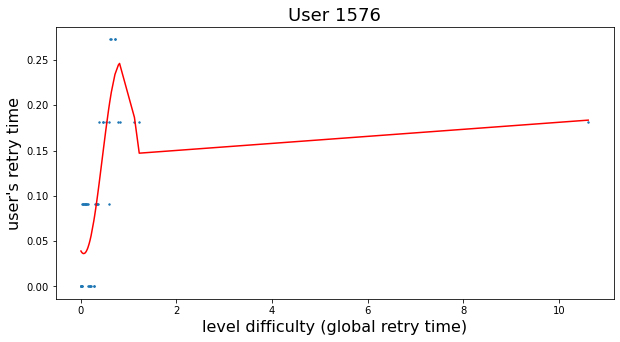

user id: 1047, length: 40
0.10*x+0.27*sin(x*0.27+-1.30)+3.59


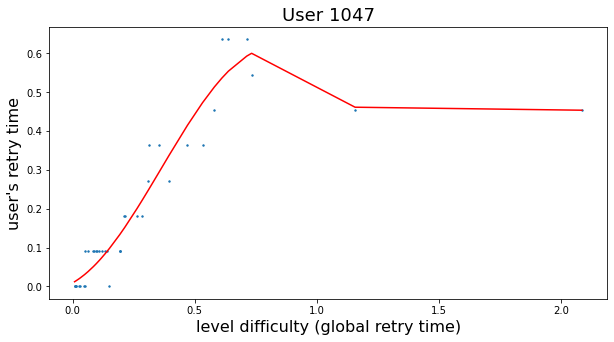

In [458]:
for row in top_fit.iterrows():
    print("user id: %d, length: %d"%(row[1].user_id,row[1].length))
    params = row[1].iloc[4:].tolist()
    #print("%.2f*x+%.2f*sin(x+%.2f)+%.2f"%(params[0],params[1],params[2],params[3]))
    print("%.2f*x+%.2f*sin(x*%.2f+%.2f)+%.2f"%(params[0],params[1],params[2],params[3],params[4]))
    uid = row[1].user_id
    x = retry_dedup.loc[retry_dedup.user_id==uid].global_retrytime.to_numpy()
    y = retry_dedup.loc[retry_dedup.user_id==uid].retry_time.to_numpy()
    y_cum = y.cumsum()
    y_smooth = np.array([(y_cum[min(i+Neighbor,len(y)-1)]-y_cum[max(i-Neighbor,0)])/(2*Neighbor+1) for i in range(len(y))])
    
    plot_curve(x,y_smooth,curve=curve_fun,params=params,uid=uid)

user id: 619, length: 697
0.89*x+0.96*sin(x*0.71+-4.00)+1.53


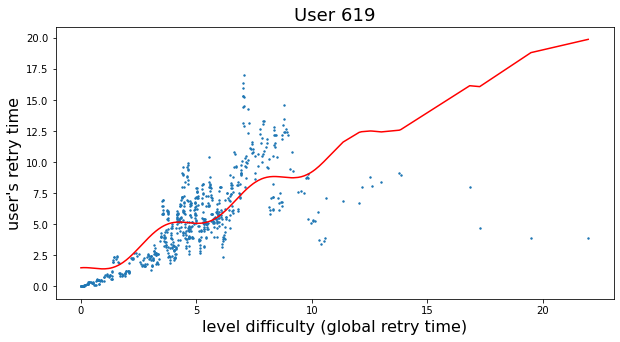

user id: 1045, length: 610
0.78*x+0.94*sin(x*-0.47+-0.80)+1.21


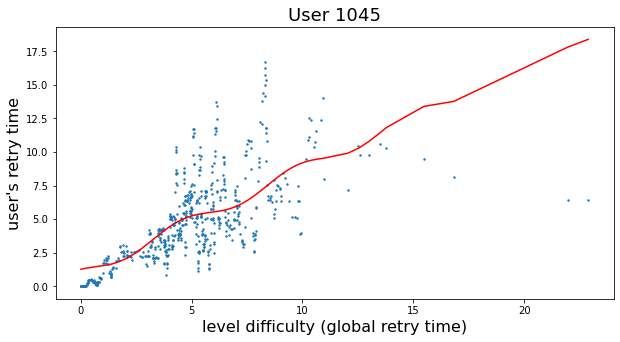

user id: 1853, length: 268
0.33*x+2.34*sin(x*-3.95+2.57)+0.34


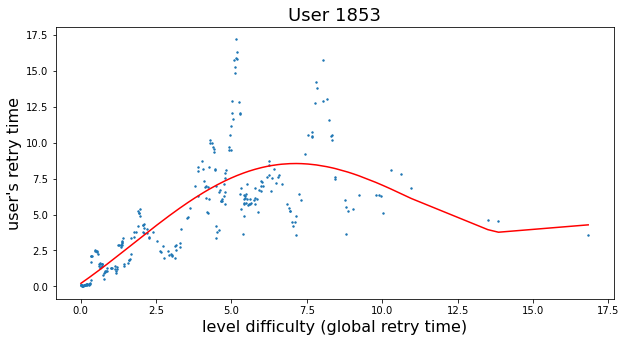

user id: 252, length: 482
1.02*x+0.82*sin(x*0.80+3.43)+1.20


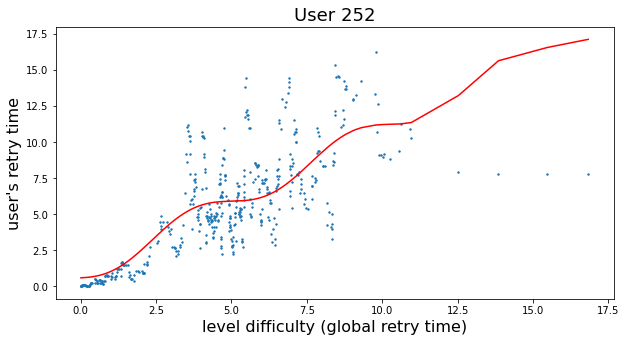

user id: 1772, length: 458
-484.96*x+2118.08*sin(x*34827.82+3.20)+-0.01


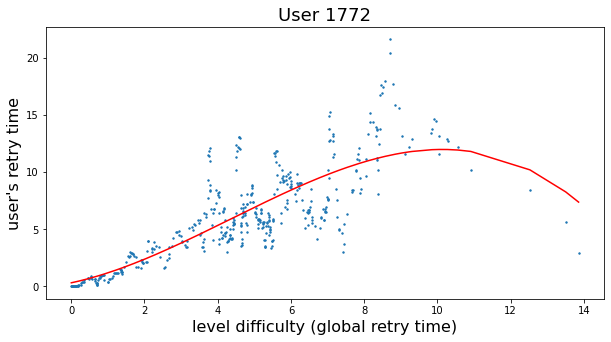

user id: 1139, length: 560
0.65*x+1.25*sin(x*-0.32+-0.10)+1.01


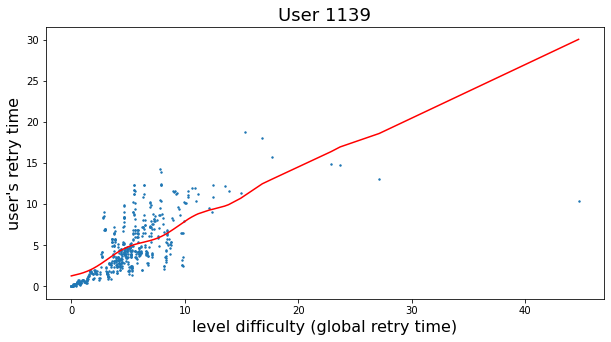

user id: 1105, length: 675
1.24*x+-0.21*sin(x*-0.53+-0.34)+2.41


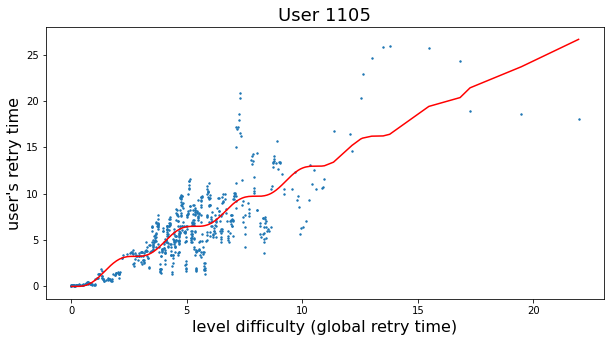

user id: 1499, length: 693
0.72*x+0.65*sin(x*0.37+-1.59)+1.09


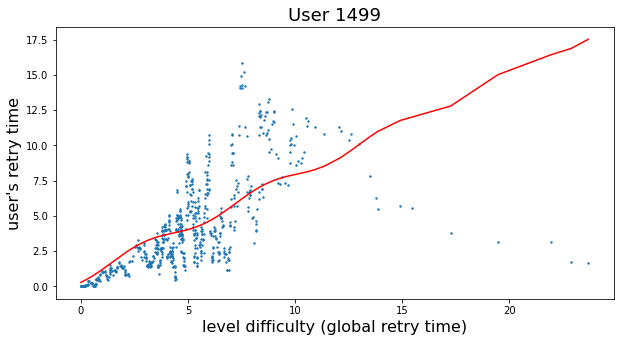

user id: 1053, length: 147
1.10*x+2.14*sin(x*1.21+-3.37)+2.92


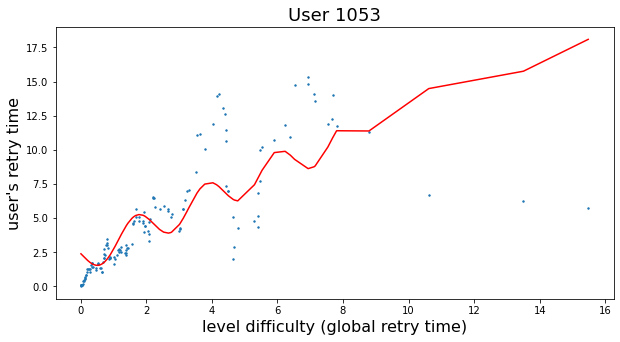

user id: 1446, length: 264
0.85*x+3.00*sin(x*1.74+-16.07)+3.37


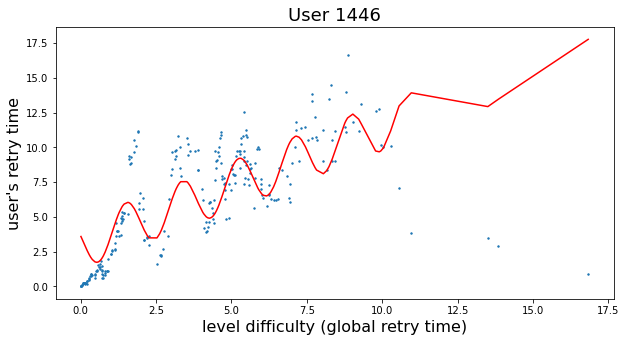

user id: 239, length: 427
1.08*x+1.32*sin(x*0.59+-3.06)+2.40


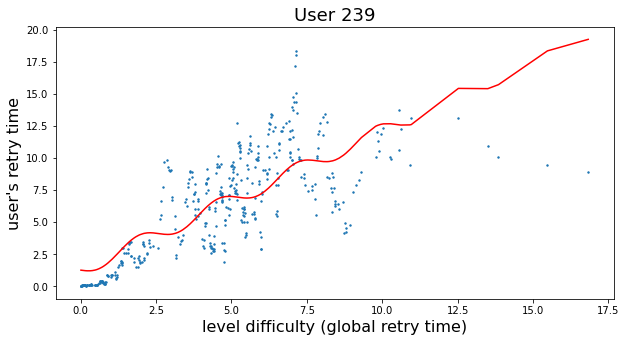

user id: 466, length: 555
0.63*x+2.37*sin(x*0.72+-2.41)+1.53


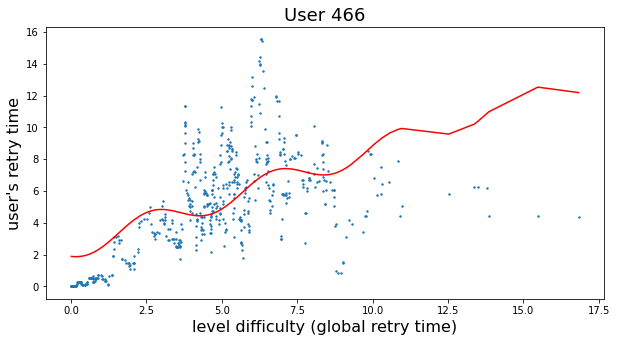

user id: 230, length: 225
0.81*x+0.98*sin(x*1.03+3.72)+2.38


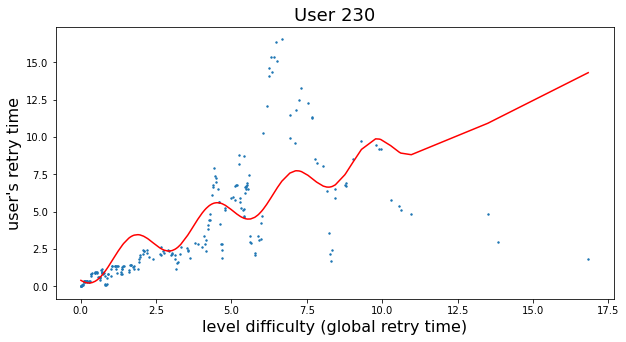

user id: 655, length: 270
0.91*x+2.61*sin(x*2.05+-2.24)+1.22


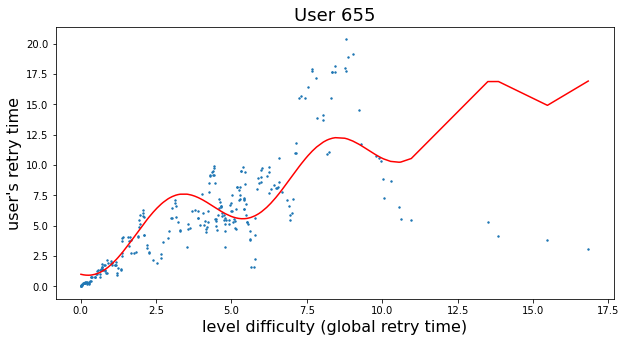

user id: 1003, length: 337
0.77*x+1.64*sin(x*-1.16+-0.16)+1.26


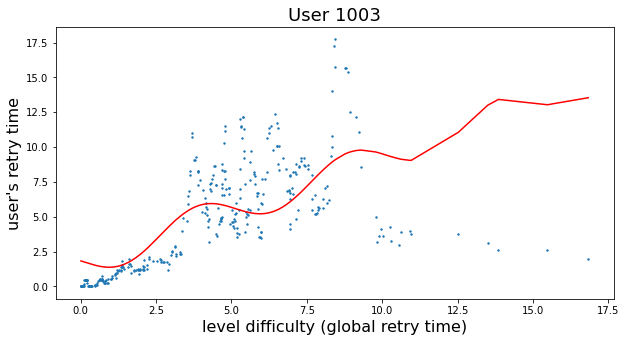

user id: 195, length: 822
1.06*x+0.44*sin(x*-0.77+1.42)+0.60


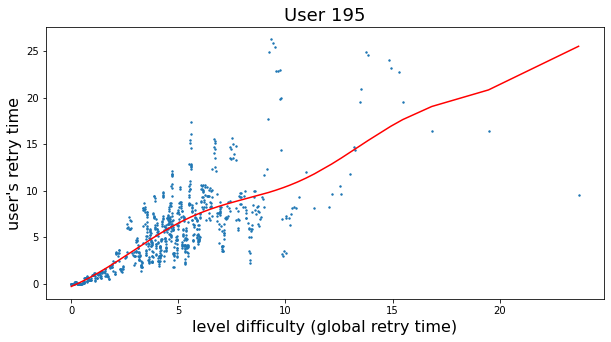

user id: 1929, length: 786
1.03*x+1.45*sin(x*-1.69+-0.01)+0.83


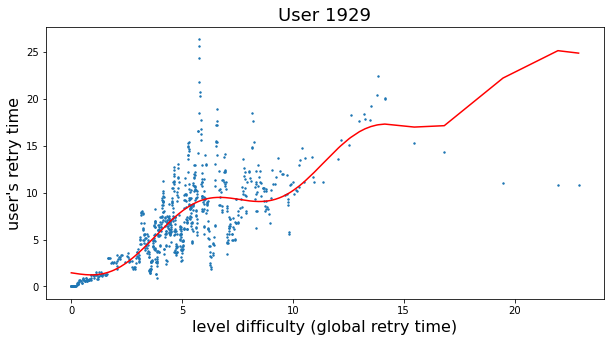

user id: 915, length: 331
-0.07*x+5.51*sin(x*5.22+-1.42)+0.31


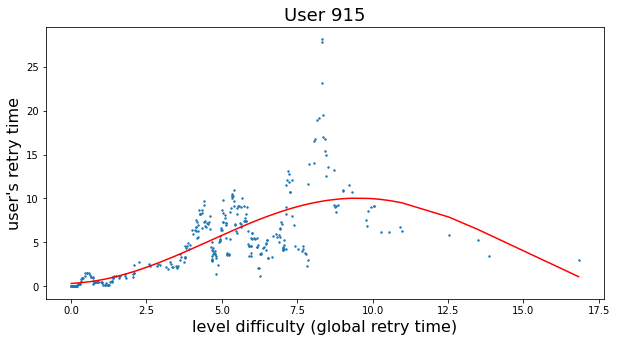

user id: 514, length: 259
0.80*x+2.94*sin(x*-2.30+-5.92)+2.41


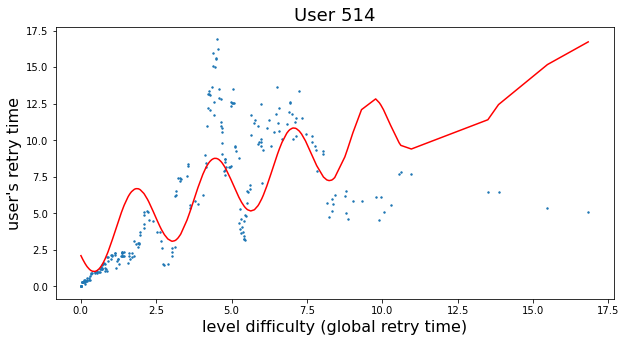

user id: 784, length: 513
0.85*x+1.72*sin(x*0.60+-4.70)+1.04


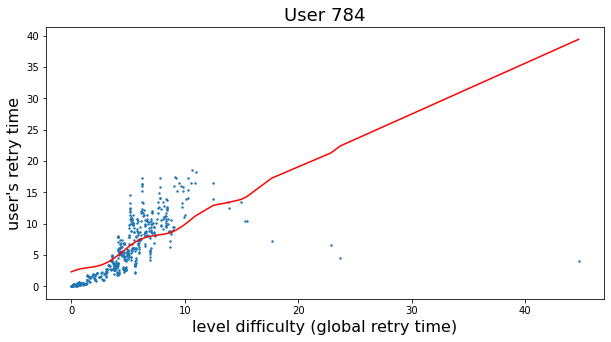

In [460]:
for row in worst_fit.iterrows():
    print("user id: %d, length: %d"%(row[1].user_id,row[1].length))
    params = row[1].iloc[4:].tolist()
    #print("%.2f*x+%.2f*sin(x+%.2f)+%.2f"%(params[0],params[1],params[2],params[3]))
    print("%.2f*x+%.2f*sin(x*%.2f+%.2f)+%.2f"%(params[0],params[1],params[2],params[3],params[4]))
    uid = row[1].user_id
    x = retry_dedup.loc[retry_dedup.user_id==uid].global_retrytime.to_numpy()
    y = retry_dedup.loc[retry_dedup.user_id==uid].retry_time.to_numpy()
    y_cum = y.cumsum()
    y_smooth = np.array([(y_cum[min(i+Neighbor,len(y)-1)]-y_cum[max(i-Neighbor,0)])/(2*Neighbor+1) for i in range(len(y))])
    
    plot_curve(x,y_smooth,curve=curve_fun,params=params,uid=uid)

user id: 1772, length: 458
-484.96*x+2118.08*sin(x*34827.82+3.20)+-0.01


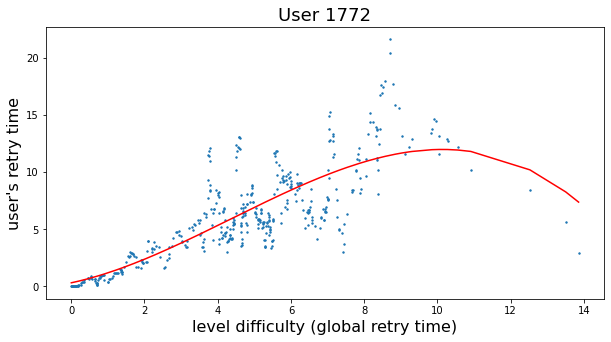

In [466]:
uid = 1772
row = fit_results_sin.loc[fit_results_sin.user_id==uid]
print("user id: %d, length: %d"%(row.user_id,row.length))
params = row.iloc[0,4:].tolist()
print("%.2f*x+%.2f*sin(x*%.2f+%.2f)+%.2f"%(params[0],params[1],params[2],params[3],params[4]))
x = retry_dedup.loc[retry_dedup.user_id==uid].global_retrytime.to_numpy()
y = retry_dedup.loc[retry_dedup.user_id==uid].retry_time.to_numpy()
y_cum = y.cumsum()
y_smooth = np.array([(y_cum[min(i+Neighbor,len(y)-1)]-y_cum[max(i-Neighbor,0)])/(2*Neighbor+1) for i in range(len(y))])

plot_curve(x,y_smooth,curve=curve_fun,params=params,uid=uid)